<h1><center><strong>Interconnect - Tasa de cancelación de clientes</strong></center></h1>

## **1. Descripción del proyecto**

### **1.1 Problema de negocio**

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

**Servicios de Interconnect**

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### **1.2 Objetivos**

Este proyecto tiene tres objetivos principales:

* Analizar los datos proporcionados, para identificar factores que pueden influir en la tasa de abandono de clientes.

* Desarrollar modelos de machine learning que puedan predecir de forma efectiva la probabilidad de deserción de los clientes a los servicios de Interconnect.

* Generar recomendaciones promocionales relevantes para mitigar el abandono de clientes y fomentar su fidelización.

### **1.3 Propuesta del proyecto**

Este proyecto se llevará a cabo en cuatro fases:

* Preprocesamiento de datos: Mejorar la calidad de los datos para facilitar un análisis más efectivo.

* Análisis exploratorio de datos: Investigar los factores que influyen en la tasa de abandono de clientes.

* Modelado de machine learning: Desarrollar un modelo de aprendizaje automático capaz de predecir de manera precisa el abandono.

* Informe final y recomendaciones: Resumir la implementación del proyecto y proponer estrategias promocionales basadas en los factores clave que contribuyen al abandono de clientes en los servicios de Interconnect.

## **2. Preparación de los datos**

### **2.1 Descripción de los datos**

Los datos consisten en archivos obtenidos de diferentes fuentes y se pueden obtener en la ruta `datasets/final_provider/`.

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

### **2.2 Ambiente y Librerias**

In [180]:
# Importar librerias requeridas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Variable de aleatoriedad
seed = 200

### **2.3 Funciones**

In [181]:

# 1. Contexto general del conjunto de datos

def info_data(data):
    print('1. Tabla de datos')
    display(data.sample(10))
    print('='*100)
    print()

    print('2. Registros y variables')
    print()
    print('Registros: ', data.shape[0])
    print()
    print('Variables: ', data.shape[1])
    print('='*100)
    print()

    print('3. Resumen general del dataset')
    print(data.info())
    print('='*100)
    print()

    print('4. Resumen estadistico del dataset')
    print()
    print(data.describe())
    print('='*100)
    print()

    print('5. Valores duplicados por variable')
    print()
    print(data.duplicated().sum())
    print('='*100)
    print()

    print('6. Valores ausentes por variable')
    print()
    print(data.isna().sum())
    print('='*100)
    print()


# 2.Modifica formato nombre de columnas (snake_case)

def camel_to_snake(string):
    string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    string = re.sub('(.)([0-9]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()


# 3. Analiza distribución y elabora gráfico circular 

def analyze_column(column):
    value_counts = data[column].value_counts()
    percentages = (value_counts / len(data)) * 100
    df = pd.DataFrame({'Cantidad de valores': value_counts, 'Porcentajes': percentages.map('{:.2f}%'.format)})
    display(df)
    plt.pie(value_counts, labels=value_counts.index, autopct='%.1f%%')
    plt.title(f'Distribución de {column}') 
    plt.show()


# 4. Define a function to calculate the churn rate and visualize it

def analyze_churn_rate(column):

    churn_rate = data.groupby(column, observed=True)['churn'].value_counts().unstack(fill_value=0)
    churn_rate['churn_rate'] = (churn_rate[1] / churn_rate.sum(axis=1) * 100).round(2).astype(str) + '%'
    churn_rate.plot(kind='bar', stacked=False)
    plt.title('Tasa de abandono por ' + column)
    plt.xlabel(column)
    plt.ylabel('Cantidad')
    plt.legend(title='Churn', loc='upper right')
    plt.gca().set_xticklabels(churn_rate.index, rotation=45, ha='right')
    plt.show()
    return churn_rate


# 5. Calcula las métricas AUC-ROC, F1-Score y Accuracy sin ajuste de hiperparámetros para evaluar los modelos

def calculate_metrics(model, features_train, target_train, features_test, target_test, model_name):

    proba_predictions_train = cross_val_predict(model, features_train, target_train, cv=5, method='predict_proba')
    positive_probabilities_train = proba_predictions_train[:, 1]
    auc_roc_train = roc_auc_score(target_train, positive_probabilities_train)
    predictions_train = model.predict(features_train)
    accuracy_train = accuracy_score(target_train, predictions_train)
    f1_train = f1_score(target_train, predictions_train)
    predictions_test = model.predict(features_test)
    auc_roc_test = roc_auc_score(target_test, predictions_test)
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_test = f1_score(target_test, predictions_test)
    results_df = pd.DataFrame({'Modelo': [model_name],
                               'AUC-ROC Entrenamiento': [auc_roc_train],
                               'AUC-ROC Prueba': [auc_roc_test],
                               'F1-Score Entrenamiento': [f1_train],
                               'F1-Score Prueba': [f1_test],
                               'Accuracy Entrenamiento': [accuracy_train],
                               'Accuracy Prueba': [accuracy_test]})    
    return results_df


# 6. Calcula las métricas AUC-ROC, F1-Score y Accuracy con ajuste de hiperparámetros para evaluar los modelos

def hyperparam_tuning_calcule_metrics(model, param_distributions, features_train, target_train, features_test, target_test, model_name):
    
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions, scoring='roc_auc', n_iter=10, cv=5, n_jobs=-1, random_state=seed)
    random_search.fit(features_train, target_train)
    best_model = random_search.best_estimator_
    proba_predictions_train = best_model.predict_proba(features_train)
    proba_predictions_test = best_model.predict_proba(features_test)
    positive_probabilities_train = proba_predictions_train[:, 1]
    positive_probabilities_test = proba_predictions_test[:, 1]
    auc_roc_train = roc_auc_score(target_train, positive_probabilities_train)
    auc_roc_test = roc_auc_score(target_test, positive_probabilities_test)
    predictions_train = best_model.predict(features_train)
    predictions_test = best_model.predict(features_test)
    accuracy_train = accuracy_score(target_train, predictions_train)
    accuracy_test = accuracy_score(target_test, predictions_test)
    f1_train = f1_score(target_train, predictions_train)
    f1_test = f1_score(target_test, predictions_test)
    print("Mejores parámetros:", random_search.best_params_)
    results_df = pd.DataFrame({'Modelo': [model_name],
                               'AUC-ROC Entrenamiento': [auc_roc_train],
                               'AUC-ROC Prueba': [auc_roc_test],
                               'F1-Score Entrenamiento': [f1_train],
                               'F1-Score Prueba': [f1_test],
                               'Accuracy Entrenamiento': [accuracy_train],
                               'Accuracy Prueba': [accuracy_test]})
    return results_df

### **2.4 Carga y lectura de datos**

In [182]:
# Asignación de los conjuntos de datos en variables respectivas

try:
    contract, internet, personal, phone = pd.read_csv('files/datasets/input/contract.csv')\
                                        , pd.read_csv('files/datasets/input/internet.csv')\
                                        , pd.read_csv('files/datasets/input/personal.csv')\
                                        , pd.read_csv('files/datasets/input/phone.csv')

except:
    contract, internet, personal, phone = pd.read_csv('contract.csv')\
                                        , pd.read_csv('internet.csv')\
                                        , pd.read_csv('personal.csv')\
                                        , pd.read_csv('phone.csv')

In [183]:
# Muestra de los datos

datasets = {'contract': contract,
            'internet': internet,
            'personal': personal,
            'phone': phone}


for name, data in datasets.items():
    print(f"Datos de '{name}'")
    display(data.head())
    print()

Datos de 'contract'


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Datos de 'internet'


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Datos de 'personal'


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Datos de 'phone'


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [184]:
# Verificar tamaño de cada conjunto de datos

for name, data in datasets.items():
    print(f"'{name}' tiene {data.shape[0]} filas y {data.shape[1]} columnas")
    

'contract' tiene 7043 filas y 8 columnas
'internet' tiene 5517 filas y 8 columnas
'personal' tiene 7043 filas y 5 columnas
'phone' tiene 6361 filas y 2 columnas


Según la información obtenida, la columna `customerID` esta en todos los datasets, la cual, actúa como un identificador único establecido a cada cliente. Con el fin de sintetizar el análisis, se hara la unión de todos los datos en un solo conjunto de datos, mediante la columna `customerID`.

Tambien es posible observar, que cada dataset tiene un tamaño diferente, siendo `contrato` y `personal` los que tienen más registros. Para conservar todos los datos, se utilizará el método de combinación merge, con el parámetro `how = 'outer'`.

In [185]:
# Combinar archivos en un solo conjunto de datos

data = contract.merge(personal, on='customerID', how='outer')\
               .merge(internet, on='customerID', how='outer')\
               .merge(phone, on='customerID', how='outer')

print(data.shape)
print()
print(data.head())

(7043, 20)

   customerID   BeginDate              EndDate            Type  \
0  0002-ORFBO  2019-05-01                   No        One year   
1  0003-MKNFE  2019-05-01                   No  Month-to-month   
2  0004-TLHLJ  2019-09-01  2020-01-01 00:00:00  Month-to-month   
3  0011-IGKFF  2018-12-01  2020-01-01 00:00:00  Month-to-month   
4  0013-EXCHZ  2019-09-01  2019-12-01 00:00:00  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges  gender  \
0              Yes      Mailed check            65.6        593.3  Female   
1               No      Mailed check            59.9        542.4    Male   
2              Yes  Electronic check            73.9       280.85    Male   
3              Yes  Electronic check            98.0      1237.85    Male   
4              Yes      Mailed check            83.9        267.4  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes        Yes             DSL       

Reorganización final del conjunto de datos, orden y descripción de las columnas

1. customerID: Identificador unico de cada cliente.
2. BeginDate: Fecha de contratación del servicio.
3. EndDate: Fecha de término del servicio.
4. Type: Tipo de servicio (mensual, anual, bianual).
5. PaperlessBilling: Facturación electrónica (yes/no).
6. PaymentMethod: Método de pago que utiliza por el cliente.
7. MonthlyCharges: Cargos mensuales por servicio.
8. TotalCharges: Cargos totales por utilizar el servicio.
9. gender: Género del cliente (Masculino/Femenino)
10. SeniorCitizen: Cliente es adulto mayor (yes/no).
11. Partner: Cliente tiene pareja/esposa (yes/no).
12. Dependents: Cliente tiene hijos (yes/no).
13. InternetService: Tipo de servicio de internet utilizado.
14. OnlineSecurity: Servicio de seguridad en línea (yes/no).
15. OnlineBackup: Servicio de respaldo en línea (yes/no).
16. DeviceProtection: Servicio de protección de dispositivos (yes/no).
17. TechSupport: Servicio de soporte técnico (yes/no).
18. StreamingTV: Servicio de Streaming de televisión (yes/no).
19. StreamingMovies: Servicio de Streaming de películas (yes/no).
20. MultipleLines: Servicio de multiples líneas (yes/no).

### **2.5 Información preliminar**

In [186]:
# Inspección del conjunto de datos

info_data(data)

1. Tabla de datos


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3555,5038-ETMLM,2014-02-01,No,Two year,Yes,Bank transfer (automatic),113.65,8182.75,Female,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6213,8782-LKFPK,2016-06-01,No,Month-to-month,Yes,Mailed check,90.40,4063,Male,0,No,No,Fiber optic,No,No,Yes,No,No,Yes,Yes
4578,6461-PPAXN,2017-03-01,No,One year,Yes,Bank transfer (automatic),54.95,1916,Female,0,Yes,Yes,DSL,Yes,No,No,Yes,No,No,No
2777,3951-NJCVI,2016-08-01,No,Month-to-month,Yes,Electronic check,95.05,3944.5,Female,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
6615,9399-APLBT,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,74.70,74.7,Female,0,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,No
4925,6927-WTFIV,2018-04-01,2019-12-01 00:00:00,Month-to-month,No,Credit card (automatic),71.30,1389.2,Male,1,No,No,Fiber optic,No,No,No,No,No,No,No
3098,4443-EMBNA,2014-03-01,No,Two year,No,Bank transfer (automatic),24.75,1836.9,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2133,3063-QFSZL,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,55.40,55.4,Female,0,No,No,DSL,No,No,No,No,No,Yes,No
754,1098-KFQEC,2015-07-01,No,Two year,No,Credit card (automatic),19.40,1083,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
355,0520-FDVVT,2016-12-01,2019-11-01 00:00:00,One year,Yes,Bank transfer (automatic),102.35,3626.1,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No



2. Registros y variables

Registros:  7043

Variables:  20

3. Resumen general del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 1

**Hallazgos**

- El conjunto de datos final contiene 7043 observaciones y 20 variables.

- Las tablas de `ìnternet` y `phone` tenian valores faltantes, los cuales se traspasaron al dataset final.

- Estandarizar el formato de nombres de las columnas para mantener la coherencia de la tabla.

- No existen valores duplicados en el conjunto de datos.

- Gran parte de las variables del set de datos son tipo object, incluyendo `BeginDate` y `EndDate` que deben ser tipo datetime, y `TotalCharges`, que debe ser tipo float.

- Solo existen 2 columnas numéricas, `SeniorCitizen` y `MonthlyCharges`.

-  `MonthlyCharges` tiene una media de 64.76 dólares por mes, y una mediana de 70.35 dólares, lo que puede implicar presencia de valores atípicos(outliers).

-  `SeniorCitizen` solo contiene valores 1 y 0, para indicear si el clientes es adulto mayor o no.

-  Los valores ausentes estan presentes en 8 columnas, y corresponden a casi un 22% del total de registros, por ello, es necesario indagar y aplicar métodos y/o técnicas apropiadas para su tratamiento, con el fin de conservar la integridad de los datos.

-  Las columnas se componen de datos de 'yes/no', deben ser representadas de manera uniforma como la columna `SeniorCitizen`.

-  `TotalCharges` tiene tipo de dato erroneo, lo que impide ver sus valores en el análisis descriptivo.

-  `EndDate` sera la colummna objetivo del modelo de machine learning del proyecto, la cual indica el estado del cliente, si sigue usando los servicios o los ha dado de baja.

-  Al ser un modelo de clasificación, es necesario que la columna objetivo este representada por datos de valores binarios, por lo que es necesario transformar sus datos a valores de 0 y 1. 




En el siguiente apartado, se procedera a depurar el conjunto de datos.



### **2.6 Pre-procesamiento de datos**

#### **2.6.1 Estandarizar formato de nombre de columnas**

In [187]:
# Aplicación de función 'camel_to_snake' para estandarizar el formato
# Verificar resultados

new_cols = []
for string in data.columns:
    new_cols.append(camel_to_snake(string))

data.columns = new_cols
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

#### **2.6.2 Modificación de tipos de datos**

Las columnas que requieren estos cambios son las siguientes:

- `begin_date` y `end_date` que deben ser convertidas de tipo object a tipo datetime.
- `total_charges` que será modificada de tipo object a tipo float.
- Las columnas categóricas, con valores 'yes/no', serán modificadas a valores binarios, donde 'yes' será valorizado como 1, y 'no' como 0. Esto aplica para las columnas `partner`, `dependents`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`,`multiple_lines`.

##### **2.6.2.1 Columnas `begin_date` y `end_date`**

In [188]:
# Verificar valores unicos de la columna `begin_date` y `end_date`

print('Datos únicos de la columna "begin_date"')
print()
print(data['begin_date'].unique())
print()
print('='*100)
print()
print('Datos únicos de la columna "end_date"')
print()
print(data['end_date'].unique())

Datos únicos de la columna "begin_date"

['2019-05-01' '2019-09-01' '2018-12-01' '2014-03-01' '2014-11-01'
 '2019-07-01' '2014-09-01' '2015-08-01' '2014-02-01' '2015-06-01'
 '2017-04-01' '2020-01-01' '2016-03-01' '2019-10-01' '2015-12-01'
 '2018-10-01' '2018-03-01' '2019-11-01' '2015-07-01' '2017-12-01'
 '2014-05-01' '2017-01-01' '2016-01-01' '2014-08-01' '2014-07-01'
 '2018-06-01' '2016-07-01' '2015-03-01' '2019-02-01' '2017-11-01'
 '2018-01-01' '2017-09-01' '2017-03-01' '2014-10-01' '2016-11-01'
 '2016-10-01' '2016-09-01' '2019-08-01' '2017-08-01' '2014-04-01'
 '2015-05-01' '2015-04-01' '2017-06-01' '2015-10-01' '2017-05-01'
 '2019-04-01' '2018-02-01' '2015-01-01' '2018-07-01' '2016-06-01'
 '2018-11-01' '2019-12-01' '2014-12-01' '2019-03-01' '2019-06-01'
 '2014-01-01' '2016-04-01' '2018-08-01' '2018-04-01' '2015-02-01'
 '2016-02-01' '2017-07-01' '2019-01-01' '2015-09-01' '2014-06-01'
 '2018-09-01' '2017-10-01' '2017-02-01' '2015-11-01' '2016-08-01'
 '2016-05-01' '2018-05-01' '2016-12

Los datos de fecha en ambas columnas empiezan desde el día 01, la informacion horaria no es relevante, por ello, se extraera el mes y el año de dichas columnas.

La columna `end_date`, contiene una cantidad considerablemente menor de valores, esta indica siel cliente sigue suscrito o ha abandonado el servicio.

Finalmente, a partir de la columna `end_date` se agregara una columna llamada `churn`, la cual contendrá valores binarios, 0 y 1. El valor 0 senalará que el cliente continua activo, mientras que el valor 1, indicará que el cliente ha salido de la compañia. Los fundamentos que respaldan esta determinación, se basan es que la columna `end_date` tiene solo 5 valores únicos, los cuales corresponden a 4 meses distintos entre octubre de 2019 y enero de 2020, mientras que en la columna `begin_date` los registros de clientes comienzan en octubre de 2013 hasta febrero 2020. Por lo tanto, se procede a eliminar la columna `end_date` del conjunto de datos.

In [189]:
# Convierte columna `begin_date` a formato datetime
# Extrae solo mes y año de la fecha
# Verificar resultado

data['begin_date'] = data['begin_date'].apply(pd.to_datetime).dt.to_period('M')
data['begin_date'].head()

0    2019-05
1    2019-05
2    2019-09
3    2018-12
4    2019-09
Name: begin_date, dtype: period[M]

In [190]:
# Agregar columna `churn`
# Eliminar columna `end_date`
# Verificar resultado

data['churn'] = data['end_date'].apply(lambda x : 0 if x == 'No' else 1)
data.drop('end_date', axis=1, inplace=True)
data['churn'].head()

0    0
1    0
2    1
3    1
4    1
Name: churn, dtype: int64

##### **2.6.2.2 Columna `total_charges`**

In [191]:
# Examinar los valores únicos de la columna `total_charges`

data['total_charges'].unique()

array(['593.3', '542.4', '280.85', ..., '742.9', '4627.65', '3707.6'],
      shape=(6531,), dtype=object)

In [192]:
# Cambiar tipo de dato de la columna `total_charges` a numérico
# Verificar resultado

data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')
data['total_charges'].head()

0     593.30
1     542.40
2     280.85
3    1237.85
4     267.40
Name: total_charges, dtype: float64

##### **2.6.2.3 Columnas Categóricas**

El conjunto de datos contiene varias columnas categóricas que solo contienen 'yes' y 'no', por lo que para simplificar el proceso de análisis, se han de modificar los valores categóricos(string) en valores binarios, donde 1 representará 'yes' y el 0 representará 'no'.

Las columnas que requieren este proceso son: `partner`, `dependents`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`,`multiple_lines`.

In [193]:
# Verificar valores únicos de cada columna, excluyendo `partner`, `dependents`, `paperless_billing`.

values_unique = pd.DataFrame({
    'online_security' : data['online_security'].unique(),
    'online_backup' : data['online_backup'].unique(),
    'device_protection' : data['device_protection'].unique(),
    'tech_support' : data['tech_support'].unique(),
    'streaming_tv' : data['streaming_tv'].unique(),
    'streaming_movies' : data['streaming_movies'].unique(),
    'multiple_lines' : data['multiple_lines'].unique()
    })

values_unique.T

,0,1,2
online_security,No,Yes,NaN
online_backup,Yes,No,NaN
device_protection,No,Yes,NaN
tech_support,Yes,No,NaN
streaming_tv,Yes,No,NaN
streaming_movies,No,Yes,NaN
multiple_lines,No,Yes,NaN


In [194]:
# Verificar valores únicos de las columnas `partner`, `dependents`, `paperless_billing`.

values_unique_2 = pd.DataFrame({
    'partner': data['partner'].unique(),
    'dependents': data['dependents'].unique(),
    'paperless_billing': data['paperless_billing'].unique()
}).T

values_unique_2

,0,1
partner,Yes,No
dependents,Yes,No
paperless_billing,Yes,No


Previamente, en el conjunto de datos original, se observó que los valores NaN correponden especificamente a los servicios de internet, por lo que solo tiene informacion de los clientes que han de utilizar dichos servicios. Por ello, los clientes que no usan servicios de internet, pueden ser tratados de forma equivalente al valor 'no'.

Por último, para simplificar el análisis, todos los valores 'yes' serán 1, y los valores 'no' y/o 'NaN' serán 0, lo que facilitará el procesamiento de las columnas categóricas dentro del conjunto de datos.

In [195]:
# Cambiar valor en columna categórica
# Cambiar tipo de dato de object(string) a integer
# Verificar resultado

cols_convert = ['partner', 
               'dependents', 
               'online_security', 
               'online_backup',                    
               'device_protection',                 
               'tech_support',    
               'streaming_tv', 
               'streaming_movies',                   
               'multiple_lines',
               'paperless_billing']

data[cols_convert] = data[cols_convert].replace({'Yes': 1, 'No': 0, np.nan: 0})
data[cols_convert] = data[cols_convert].astype(int)
data[cols_convert].head()

C:\Users\jvida\AppData\Local\Temp\ipykernel_22736\2255360716.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[cols_convert] = data[cols_convert].replace({'Yes': 1, 'No': 0, np.nan: 0})


,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,paperless_billing
0,1,1,0,1,0,1,1,0,0,1
1,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,1,0,0,0,0,1
3,1,0,0,1,1,0,1,1,0,1
4,1,0,0,0,0,1,1,0,0,1


In [196]:
# Verificar tipos de datos

data.dtypes

customer_id             object
begin_date           period[M]
type                    object
paperless_billing        int64
payment_method          object
monthly_charges        float64
total_charges          float64
gender                  object
senior_citizen           int64
partner                  int64
dependents               int64
internet_service        object
online_security          int64
online_backup            int64
device_protection        int64
tech_support             int64
streaming_tv             int64
streaming_movies         int64
multiple_lines           int64
churn                    int64
dtype: object

#### **2.6.3 Tratamiento de valores ausentes**

Gran parte de los valores ausentes del dataset fueron resueltos, en el punto anterior, durante los procesos de conversion de tipos de datos en las columnas y las transformacion de los registros 'yes/no' en valores binarios. A continuación en este punto se va a verificar si existen aún valores faltantes en el conjunto de datos. 

In [197]:
# Verificar valores ausentes

data.isna().sum()

customer_id             0
begin_date              0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
churn                   0
dtype: int64

Solo quedaron dos columnas, individualizadamente `internet_service` y `total_charges`, preservan valores faltantes tras las etapas de preprocesamiento.

##### **2.6.3.1 Columna `internet_service`**

In [198]:
# Verificar valores únicos

data['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

**Hallazgos**

- La columna `internet_service` contiene solo 3 valores únicos: 'DSL', 'Fiber optic', y NaN.


- Los valores NaN son consecuencia del proceso de combinación de los conjuntos de datos iniciales, por lo que se deduce que el valor NaN corresponde a clientes que no utilizan el servicio de internet.

- Por último, el valor NaN será reemplazado por 'no internet'

In [199]:
# Realizar reemplazo valores NaN por 'No internet'
# Verificar resultado

data['internet_service'] = data['internet_service'].fillna('No internet')
data.isna().sum()

customer_id           0
begin_date            0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
churn                 0
dtype: int64

##### **2.6.3.2 Columna `total_charges`**

In [200]:
# Verificar cantidad de valores únicos
# Verificar los valores ausentes 

print(data['total_charges'].nunique())
print()
print(data[data['total_charges'].isnull()])

6530

     customer_id begin_date      type  paperless_billing  \
945   1371-DWPAZ    2020-02  Two year                  0   
1731  2520-SGTTA    2020-02  Two year                  0   
1906  2775-SEFEE    2020-02  Two year                  1   
2025  2923-ARZLG    2020-02  One year                  1   
2176  3115-CZMZD    2020-02  Two year                  0   
2250  3213-VVOLG    2020-02  Two year                  0   
2855  4075-WKNIU    2020-02  Two year                  0   
3052  4367-NUYAO    2020-02  Two year                  0   
3118  4472-LVYGI    2020-02  Two year                  1   
4054  5709-LVOEQ    2020-02  Two year                  0   
5433  7644-OMVMY    2020-02  Two year                  0   

                 payment_method  monthly_charges  total_charges  gender  \
945     Credit card (automatic)            56.05            NaN  Female   
1731               Mailed check            20.00            NaN  Female   
1906  Bank transfer (automatic)            61.90

**Hallazgos**

- Solo 11 observaciones tienen valores NaN.
- Estos registros pueden ser eliminados, ya que no comprometen significativamente la calidad del conjunto de datos

In [201]:
# Eliminar registros del set de datos
# Verificar resultado

data.dropna(subset=['total_charges'], inplace=True)
data.isna().sum()

customer_id          0
begin_date           0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
churn                0
dtype: int64

Finalmente, todos lo datos han sido ajustados y los valores faltantes han sido resueltos.

## **3. Análisis exploratorio de datos**

Con el conjunto de datos preparado para un análisis más profundo. En este capítulo, se llevara a cabo un análisis exploratorio de datos para indagar que factores influyen en la tasa de abandono de los clientes de Interconnect.

El comienzo será explorar la correlación entre las diferentes características y la variable objetivo.

### **3.1 Correlación Variables Númericas**

In [202]:
# Verificar la correlacion de todas las columnas con la variable objetivo

data.select_dtypes(include='number').corr()['churn'].sort_values(ascending=False)

churn                1.000000
monthly_charges      0.192858
paperless_billing    0.191454
senior_citizen       0.150541
streaming_tv         0.063254
streaming_movies     0.060860
multiple_lines       0.040033
device_protection   -0.066193
online_backup       -0.082307
partner             -0.149982
dependents          -0.163128
tech_support        -0.164716
online_security     -0.171270
total_charges       -0.199484
Name: churn, dtype: float64

**Hallazgos**

En general, la correlación de la variable objetivo (`churn`) con el resto de las características es relativamente débil.

**Correlacón Positiva**

Ciertas columnas evidencian una correlacón positiva moderadamente alta con la variable objetivo, específicamente:

- `monthly_chargess`, sugiere que cuotas mensuales más altas, se asocian a una mayor probabilidad de abandono.

- `paperless_billing`, si el cliente utiliza la facturación sin papel, tiene mayor probabilidad de cancelar el servicio.

- `senior_citizen`, de ser el cliente un adulto mayor, tiene mayor probabilidad de cancelación.

**Correlación Negativa**

Por otra parte, existen columnas que evidencian una correlación negativa moderadamente fuerte con la variable objetivo, específicamente:

- `total_charges`, si tiene un valor bajo, aumenta la probabilidad de cancelación.

- `online_security` y `tech_support`, clientes que no utilizan servicios de seguridad en linea y/o soporte técnico, tienden a abandonar más la compañia.

- `partner` y `dependents`, si no tiene pareja/esposa, y tampoco tiene hijos o alguien dependiente, tiene una mayor posibilidad de anular los servicios.

Por último, estos hallazgos implican una indagación y análisis más profundo. 

#### **3.1.1 Correlación Positiva**

##### **3.1.1.1 Columna `monthly_charges`**

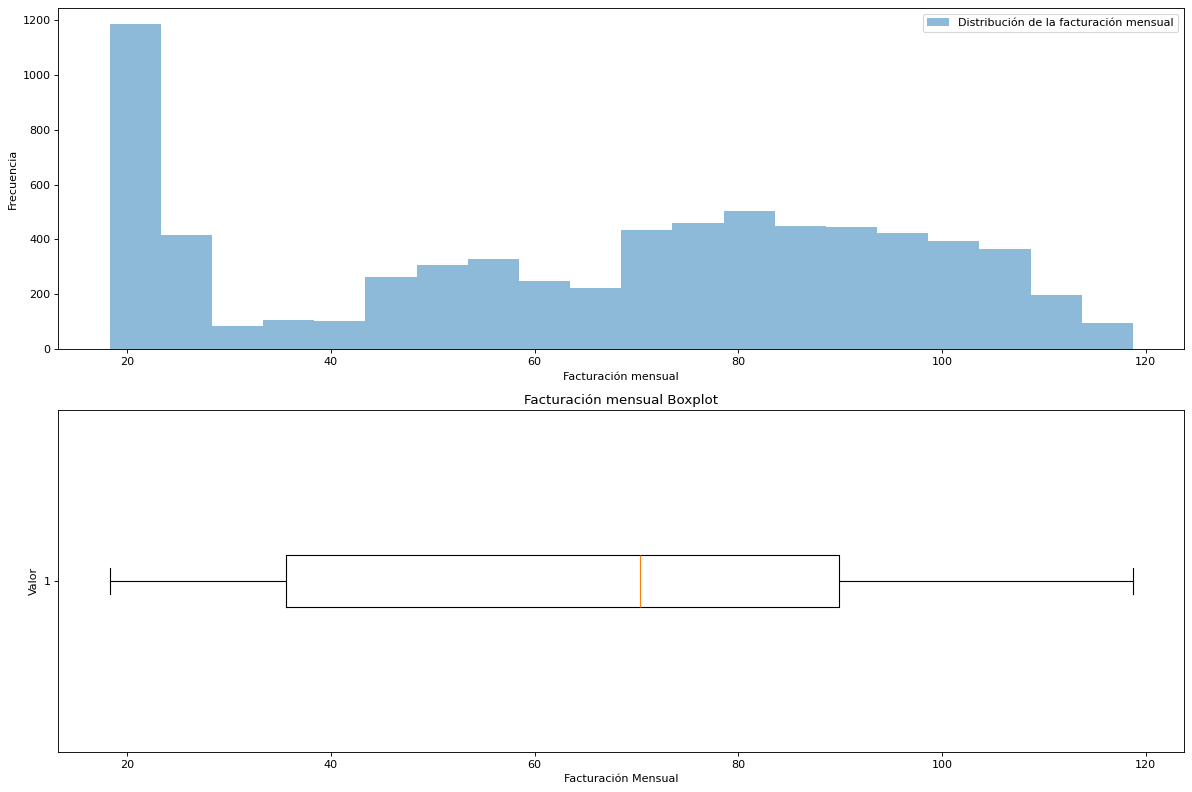

In [203]:
# Visualizar la distribución de la columna

plt.figure(figsize=(15, 10), dpi=80)

# Histograma
plt.subplot(2, 1, 1)
plt.hist(data['monthly_charges'], bins=20, alpha=0.5, label='Distribución de la facturación mensual')
plt.xlabel('Facturación mensual')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right')

# Boxplot
plt.subplot(2, 1, 2)
plt.boxplot(data['monthly_charges'], vert=False)
plt.xlabel('Facturación Mensual')
plt.ylabel('Valor')
plt.title('Facturación mensual Boxplot')

plt.tight_layout()
plt.show()

**Hallazgos**

- La distribución se concentra en los valores bajos, principalmente alrededor de los 20 dólares.

- La distribución mejora para montos de facturación superiores a los 70 dólares.

,Cantidad de valores,Porcentajes
charge_category,,
mid_high,1845,26.24%
high,1744,24.80%
low,1647,23.42%
middle,1155,16.42%
mid_low,641,9.12%


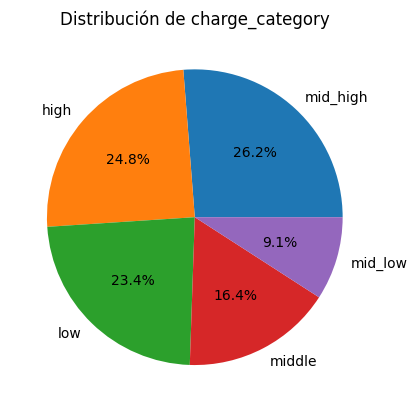

In [204]:
# Crear columna 'charge_category', a partir de los valores de 'monthly_charges'
# Calcular la distribución de valores de 'charge_category'

data['charge_category'] = pd.cut(data['monthly_charges'], bins=[0, 30, 50, 70, 90, 120], labels=['low', 'mid_low', 'middle', 'mid_high', 'high'], right=False)
analyze_column('charge_category')

**Hallazgos:**

- La distribución de los datos esta concentrada en las categórias `mid-high`, `high` y `low`, mientras las categorias `middle` y `mid-low` tienen relativamente una baja representación.

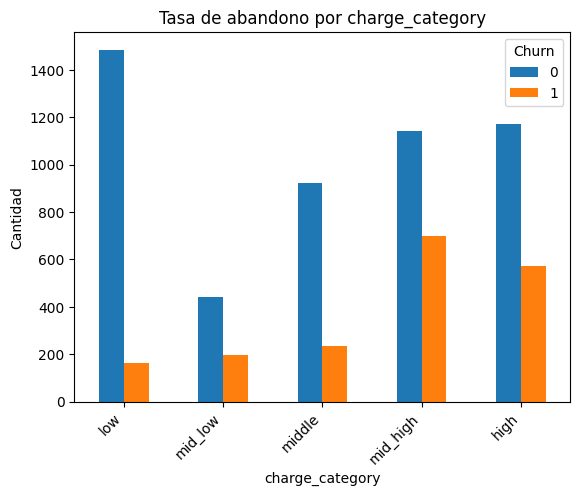

churn,0,1,churn_rate
charge_category,,,
low,1485,162,9.84%
mid_low,442,199,31.05%
middle,921,234,20.26%
mid_high,1144,701,37.99%
high,1171,573,32.86%


In [205]:
# Calcular la Tasa de Abandono basada en la columna `charge_category` y mostrar su visualización

monthly_charge_churn_rate = analyze_churn_rate('charge_category')
monthly_charge_churn_rate

**Hallazgos**

- Mediante el análisis de correlación, se deduce que un valor alto en `monthly_charges`, mayor probabilidad de cancelación.

- El análisis mas detallado confirma esta hipótesis inicial, ya que las tasas de abandono son más altas, en los segmentos 'mid-high'(70-90 dólares) y 'high'(90-120 dólares) de facturación mensual, en comparacion con grupos que tiene una facturación más baja.

**Recomendaciones**

- Interconnect debe prestar mayor interes en los clientes con facturaciones altas, ya que son más propensos a dar de baja el servicio.

- Incentivar los programas promocionales para que el objetivo de estos sean los segmentos 'mid-high' y 'high'.

##### **3.1.1.2 Columna `paperless_billing`**

Inicialmente se observó que los clientes con facturación sin papeles, representada por el valor 1 de la columna `paperless_billing`, tienden a tener mayor probabilidad de abandonar el sevicio. Se indagarán mas detalles de esta deducción.

,Cantidad de valores,Porcentajes
paperless_billing,,
1,4168,59.27%
0,2864,40.73%


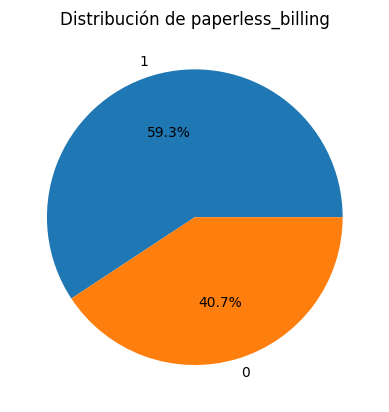

In [206]:
# Calcular la distribución de valores de 'paperless_billing'

analyze_column('paperless_billing')

Segun los datos, la mayoria de los clientes utiliza el método de facturación electrónica (sin papeles).

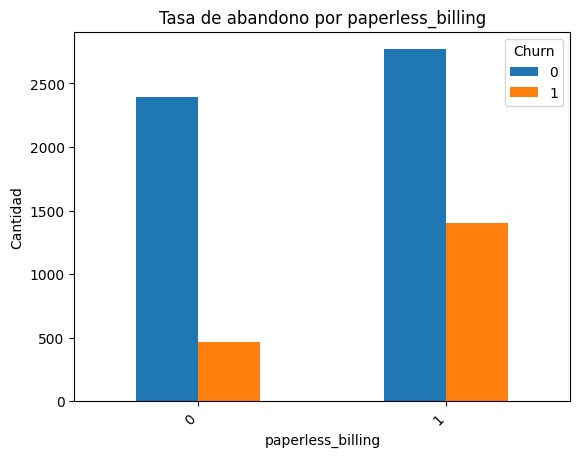

churn,0,1,churn_rate
paperless_billing,,,
0,2395,469,16.38%
1,2768,1400,33.59%


In [207]:
# Calcular la Tasa de Abandono basada en la columna `paperless_billing` y mostrar su visualización

paperless_churn_rate = analyze_churn_rate('paperless_billing')
paperless_churn_rate

**Hallasgoz**

- Los clientes que utilizan el método nde facturación sin papeles(valor 1) tienen evidentemente casi eldoble de probabilidad de anular los servicios, en comparación con los clientes que utilizan la facturación por papel(valor 0)

**Insights**

- Las facturas sin papel pueden ser más faciles de cancelar, ya que se procesan en línea, a través de la página web. 

- Las facturas físicas(recibos impresos), pueden crear una barrera para los clientes al tratar de abandonar el servicio, ya que es posible que requieran un proceso más burocratico que la cancelación en línea.

**Recomendaciones**

- Fomentar que los clientes cambien su método de facturación electrónica(sin papel) hacia la facturación física(con papel), puede que no sea prudente en la era digital, pero se puede utilizar como un disuasivo para aquellos que consideren cancelar el servicio.

- Incentivar los programas promocionales para que el objetivo de estos sean los clientes de facturación electrónica, e incentivar su permanencia.

##### **3.1.1.3 Columna `senior_citizen`**

Igual que ambos procesos anteriores, la correlación obtenida indica que los clientes de avanzada edad o con valor 1 en la columna `senior_citizen`, tienen mayor probabilidad de cambiar de compañia. Por ello, se ha de investigar, para confirmar esta hipótesis. 

,Cantidad de valores,Porcentajes
senior_citizen,,
0,5890,83.76%
1,1142,16.24%


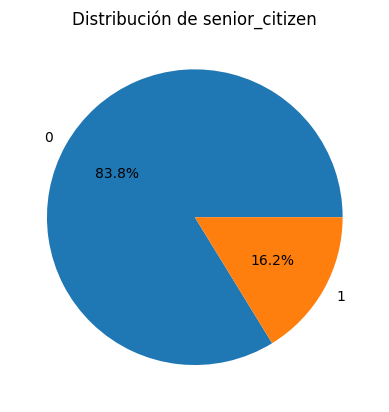

In [208]:
# Calcular la distribución de valores de 'senior_citizen'

analyze_column('senior_citizen')

Solo el 16.24% de los clientes son clasificados como adultos mayores. Ahora, se examinará la tasa de abandono de estos clientes

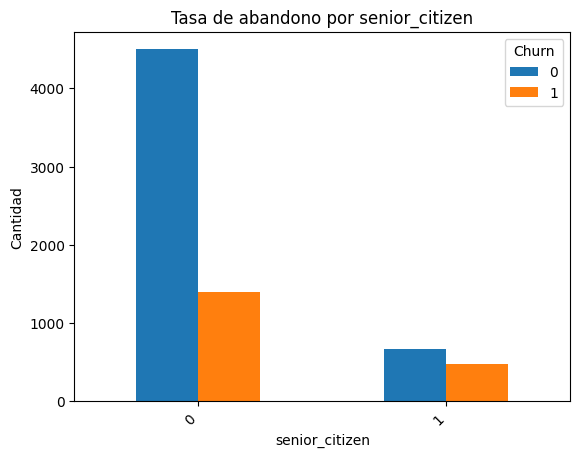

churn,0,1,churn_rate
senior_citizen,,,
0,4497,1393,23.65%
1,666,476,41.68%


In [209]:
# Calcular la Tasa de Abandono basada en la columna `paperless_billing` y mostrar su visualización

senior_citizen_churn_rate = analyze_churn_rate('senior_citizen')
senior_citizen_churn_rate

**Hallazgos**

- En términos absolutos, hay más clientes no mayores (valor 0) que han abandonado el servicio, con un total de 1393 clientes.

- Sin embargo, la tasa de cancelación entre los clientes mayores (valor 1) es significativamente más alta, alcanzando el 41.68%.

- El número de clientes mayores que han dejado el servicio es en efecto "solo" 476, pero este número es cercano al de los clientes mayores que se han quedado, que son 666, por lo que la proporción de cancelación indica aproximadamente que de 2 clientes mayores, 1 abandona el servicio.

- Esto indica que los clientes mayores tienen un mayor riesgo de cancelar el servicio.

**Recomendaciones**

- A pesar de que el número de clientes mayores es relativamente bajo, es fundamental poner atención a la proporción de cancelación y no pasarla por alto.

- Incentivar los programas promocionales para que el objetivo de estos sean los clientes adultos mayores, que se adecuen y respondan a su necesidad, con el fin de conseguir su permanencia. 

#### **3.1.2 Correlación Negativa**

En esta sección se procederá a examinar las columnas que tienen una correlación negativa significativa con la variable objetivo('churn') como son: `total_charges`, `online_security`, `tech_support`, `partner` y `dependents`

##### **3.1.2.1 Columna `total_charges`**

A diferencia de la columna `monthly_charges`, en el análisis de correlación inicial, la columna `total_charges` muestra una correlación negativa con la variable objetivo. Esto indica que a medida que el valor de `total_charges` aumenta, las probabilidades de que el cliente abandone el servicio disminuyen. Se analizará de manera mas detallada la columna `total_charges`, de la misma forma que se desarrolló en la columna `monthly_charges`.

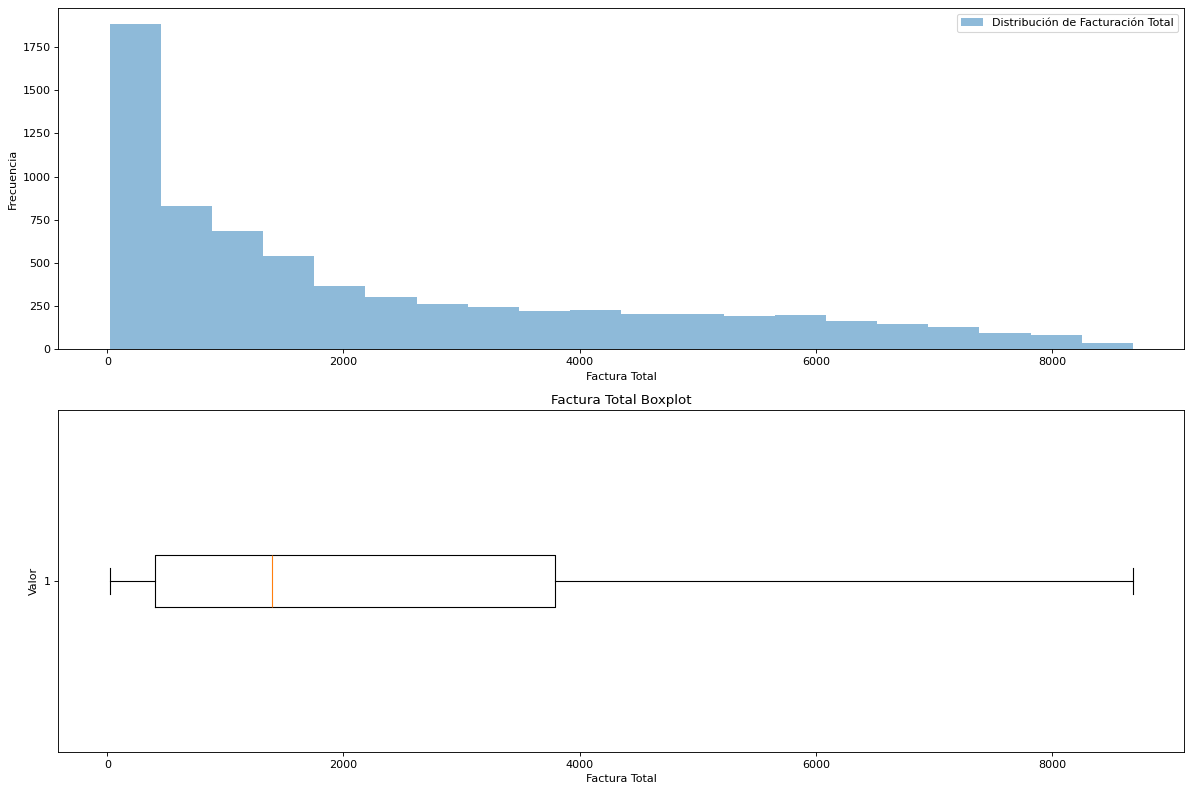

In [210]:
# Visualizar la distribución de la columna

plt.figure(figsize=(15, 10), dpi=80)

# Histograma
plt.subplot(2, 1, 1)
plt.hist(data['total_charges'], bins=20, alpha=0.5, label='Distribución de Facturación Total')
plt.xlabel('Factura Total')
plt.ylabel('Frecuencia')
plt.legend(loc='upper right')

# Boxplot
plt.subplot(2, 1, 2)
plt.boxplot(data['total_charges'], vert=False)
plt.xlabel('Factura Total')
plt.ylabel('Valor')
plt.title('Factura Total Boxplot')

plt.tight_layout()
plt.show()

**Hallazgos**

- La distribución de la columna esta sesgada a la derecha, lo que advierte que la mayoria de los clientes tiene una facturación total baja.

- Gran parte de los clientes tiene un valor total de facturación inferior a los 1000 dólares.

De forma similar, que el estudio anterior, se procede a crear una nueva columna con la agrupación de los datos basada en la columna `total_charges`.

,Cantidad de valores,Porcentajes
total_charge_category,,
low,4176,59.39%
mid_low,1208,17.18%
middle,956,13.59%
mid_high,614,8.73%
high,78,1.11%


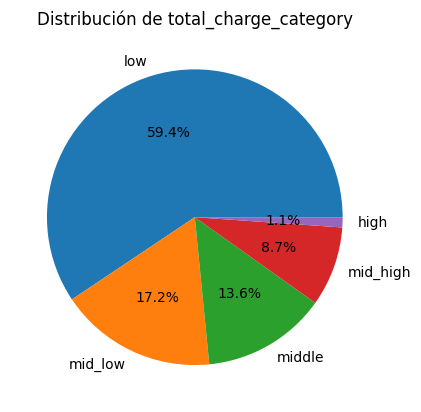

In [211]:
# Crear columna 'total_charge_category', a partir de los valores de 'total_charges'
# Calcular la distribución de valores de 'total_charge_category'

data['total_charge_category'] = pd.cut(data['total_charges'], bins=[0, 2000, 4000, 6000, 8000, 10000], labels=['low', 'mid_low', 'middle', 'mid_high', 'high'], right=False)
analyze_column('total_charge_category')

El 59.4% de los clientes, estan en el segemento 'low', lo que indica una facturación total baja. Esto deduce, que casi el 60% de los clientes tiene mayor probabilidad de influir de forma negativa en la tasa de deserción de clientes.

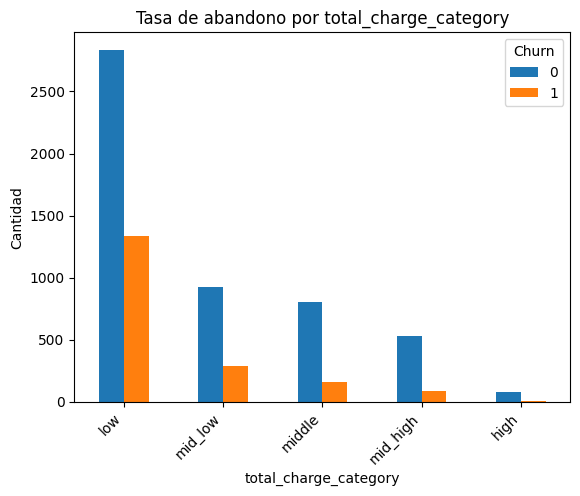

churn,0,1,churn_rate
total_charge_category,,,
low,2837,1339,32.06%
mid_low,921,287,23.76%
middle,801,155,16.21%
mid_high,529,85,13.84%
high,75,3,3.85%


In [212]:
# Calcular la Tasa de Abandono basada en la columna `total_charge_category` y mostrar su visualización

total_charge_churn_rate = analyze_churn_rate('total_charge_category')
total_charge_churn_rate

**Hallazgos**

- Al igual que el análisis preliminar, existe la correlación negativa estra `total_charges` y `churn`, que indica un mayor potencial de cancelación asociado a los valores bajos en la columna `total_charges`.

- La tasa de pérdida de clientes, para clientes con valores de facturación total bajos o muy bajos( 0 - 2000 dólares) es más alto, en comparación con valores totales de facturación más altos.

**Insights**

- Los valores más altos, señalan una suscripción de myor duración, lo que refleja la fidelización del cliente.

- Los clientes con valores de facturación total más altos, tienen probabilidades mas bajas de eliminar el servicio.

**Recomendaciones**

- Incentivar los programas promocionales para lograr fidelizar a los clientes que estan en el segmento de facturación total baja, con el objetivo de minimizar la tasa de cancelación que tiene la compañia. 

##### **3.1.2.2 Columna `online_security`**

Esta variable contiene valores binarios (0 y 1), donde el valor 0 indica que los clientes no utilizan el servicio de seguridad en línea y el valor 1 indica quien si lo utiliza.

,Cantidad de valores,Porcentajes
online_security,,
0,5017,71.35%
1,2015,28.65%


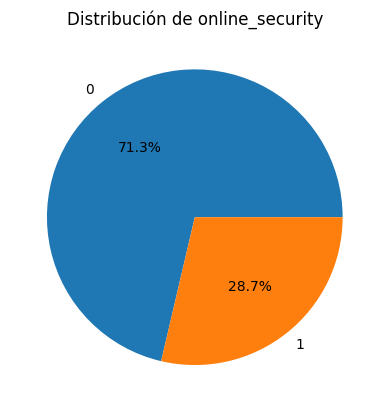

In [213]:
# Calcular la distribución de valores de 'online_security'

analyze_column('online_security')

La mayoria de los clientes no usa el servicio de seguridad en línea

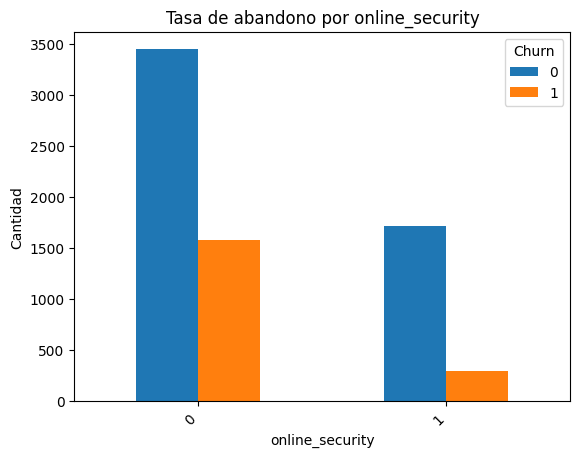

churn,0,1,churn_rate
online_security,,,
0,3443,1574,31.37%
1,1720,295,14.64%


In [214]:
# Calcular la Tasa de Abandono basada en la columna `online_security` y mostrar su visualización

online_security_churn_rate = analyze_churn_rate('online_security')
online_security_churn_rate

**Hallazgos**

- Los clientes que no utilizan el servicio de seguridad en línea estan significativamentes mas proclives a finalizar los servicios con la compañia

- La cantidad de clientes que anularon sus servicios y no usanron el servicio de seguridad en línea (1574), es aproximadamente, los clientes que usaron el servicio y eligieron seguir con sus servicios(1720).

- Si el cliente, usa el servicio de seguridad en línea o lo utilizó en algún periodo, es muy dificil que terminen su contrato.

**Insights**

- El servicio de seguridad en línea, tiene un desempeño muy relevante para el cliente, lo impacta positivamente en la tasa de cancelación.

- Los clientes que adquieren este servicio tienden a tener mayor confianza y seguridad en la compañia, y en los servicios ofrecidos por esta, lo que reduce la posibilidad de término de contrato y de la misma manera, aumenta la permanencia de los clientes. 

- Este servicio permite el aumento de tasa de retención de clientes, ya que los clientes que usan el servicio asi lo demuestran. 

**Recomendaciones**

- Resaltar y promover el servicio de seguridad en línea, con el fin de atraer más clientes, aumentar la tasa de retención y disminuir la tasa de cancelación.

##### **3.1.2.3 Columna `tech_support`**

Esta variabe tambien genera una correlación negativa con la columna `churn`.

Se puede suponer, que los clientes que utilizan este servicio tienden a ser concientes de su confiabilidad , lo que puede influir en una menor tasa de cancelación. Se ha de examinar de forma más detallada, para ver su efecto en ls tasa de deserción de clientes.

,Cantidad de valores,Porcentajes
tech_support,,
0,4992,70.99%
1,2040,29.01%


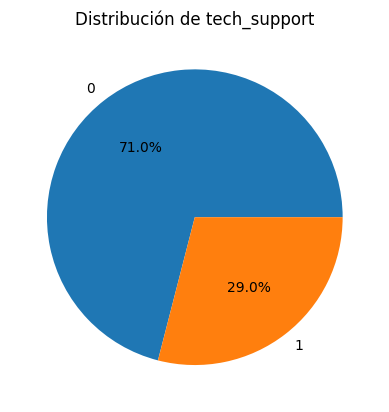

In [215]:
# Analizar la ditribución de la columna

analyze_column('tech_support')

Gran parte de los clientes asociados a la empresa, no usan los servicios de soporte técnico.

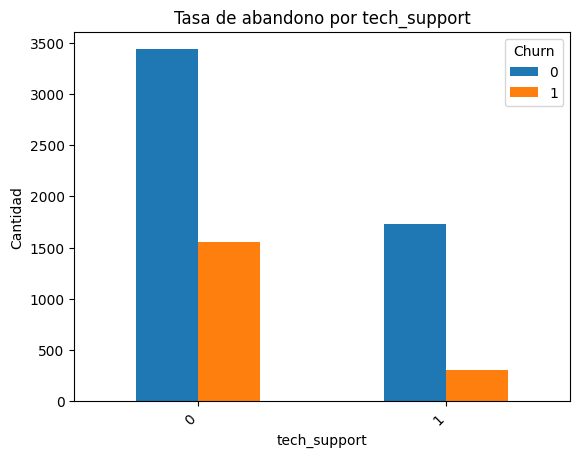

churn,0,1,churn_rate
tech_support,,,
0,3433,1559,31.23%
1,1730,310,15.2%


In [216]:
# Calcular la Tasa de Abandono basada en la columna `tech_support` y mostrar su visualización

tech_support_churn_rate = analyze_churn_rate('tech_support')
tech_support_churn_rate

**Hallazgos**

- Los clientes que no usan el servicio de soporte técnico, tienen más probabilidad de cancelar su servicio, en comparacion a los que si lo han utilizado.

- La cantidad de clientes que cancelaron sus servicios es aproximadamente equivalente con la cantidad de clientes que usan el servicio de soporte técnico y permanecen en la compañia.

**Insights**

- El servicio de soporte técnico puede desempeñar un papel fundamental en la retención de los clientes.

- Los clientes al tener acceso a la asistencia técnica, tienen mas probabilidad de sentirse respaldados y satisfechos con los servicios contratados.

**Recomendaciones**

- Reforzar y promover el servicio de soporte técnico, para incentivar a los clientes el uso del servicio.

- Con una asistencia técnica confiable, Interconnect puede cambiar la satisfacción del cliente y reducir las cancelaciones.

##### **3.1.2.4 Columna `dependents`**

En esta sección, se investigará si los clientes que no tienen hijos o personas a su cargo tienden a finalizar su contrato con más facilidad.

,Cantidad de valores,Porcentajes
dependents,,
0,4933,70.15%
1,2099,29.85%


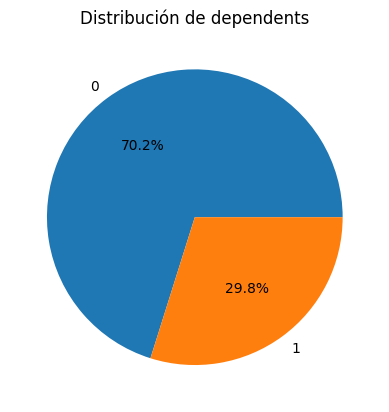

In [217]:
# Analizar la distribución de la columna

analyze_column('dependents')

La mayoria de los suscriptores no tienen hijos ni personas a su cargo.

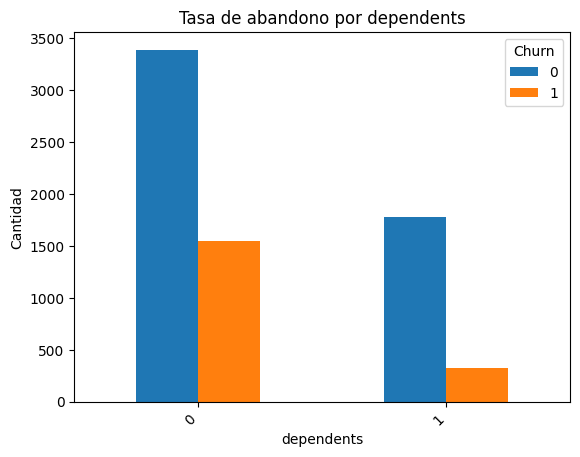

churn,0,1,churn_rate
dependents,,,
0,3390,1543,31.28%
1,1773,326,15.53%


In [218]:
# Calcular la Tasa de Abandono basada en la columna `dependents` y mostrar su visualización

dependents_churn_rate = analyze_churn_rate('dependents')
dependents_churn_rate

**Halllazgos**

- Los consumidores sin personas a su cargo tienden a tener una tasa de cancelación más alta, lo que sugiere que son más propensos a eliminar el servicio, en comparación con los que si tienen personas a su cargo.

**Insights**

- Los usuarios con personas a cargo puede que tengan más compromiso con el servicio debido a sus necesidades y preferencias familiares, lo que reduce la cancelación de la suscripción.

**Recomendaciones**

- Diseño de promociones y ofertas especiales orientadas a los consumidores con personas a su cargo, para reforzar la preferencia y la mantencion del servicio.

- Indagar con los usuarios que no tienen personas a su cargo, mediante encuestas o retroalimentación de ellos, para asi comprender de mejor manera las razones de su abandono, con el fin de implementar entrategias que aborden sus necesidades y mitiguen el aumento de la tasa de cancelación.

##### **3.1.2.5 Columna `partner`**

La última columna que muestra correlación negativa con la variable objetivo, los usuarios que tienen pareja tienden a continuar con el uso del servicio, mientras los que estan solteros tienen m ayor posibilidad de cancelar el servicio.

Se examinará la tasa de cancelación en función de esta varible con el fin de obtener más información.

,Cantidad de valores,Porcentajes
partner,,
0,3639,51.75%
1,3393,48.25%


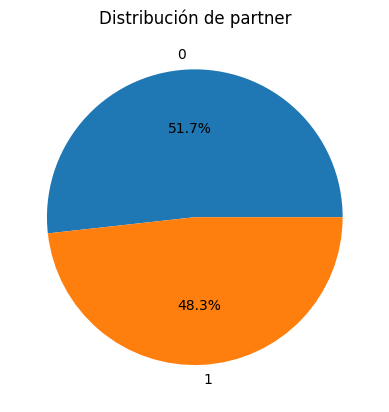

In [219]:
# Analizar la distribución de la columna

analyze_column('partner')

El número de suscriptores con y sin pareja, esta relativamente balanceado.

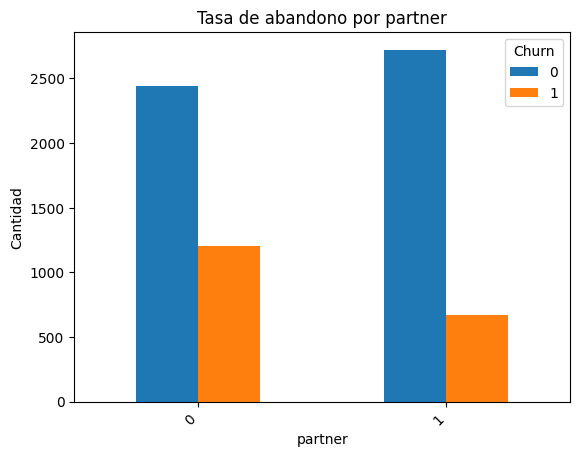

churn,0,1,churn_rate
partner,,,
0,2439,1200,32.98%
1,2724,669,19.72%


In [220]:
# Calcular la Tasa de Abandono basada en la columna `partner` y mostrar su visualización

partner_churn_rate = analyze_churn_rate('partner')
partner_churn_rate

**Hallazgos**

- la tasa de cancelación de los usuarios que no tienene pareja es significativamente más alta, llegando un 32.98% en comparación de los que si tienen pareja, cuya tasa de abandono es de 19.72%.

- La cantidad de usuarios que permanece en la compañia y no tiene pareja , es menor que aquellos que si tienen pareja.

**Insights**

- Tener pareja genera una reducción de la probabilidad de los usuarios que cancelan su suscripción.

- Los clientes sin pareja, podrian tener experiencias o necesidades diferentes que los lleva a tener una mayor tasa de abandono.

**Recomendaciones**

- Diseñar promociones para y ofertas dirigidas al segmento de usuarios que no tienen pareja, con el fin de reducir la tasad e cancelación asociado a este segmento.

### **3.2 Correlación Variables Categóricas**

Acabado el análisis de las variables númericas, el enfoque de atención cambia hacia las variables categóricas, la cuales son las siguientes: `type`, `payment_method`, `internet_service` y `gender`

#### **3.2.1 Columna `type`**

,Cantidad de valores,Porcentajes
type,,
Month-to-month,3875,55.11%
Two year,1685,23.96%
One year,1472,20.93%


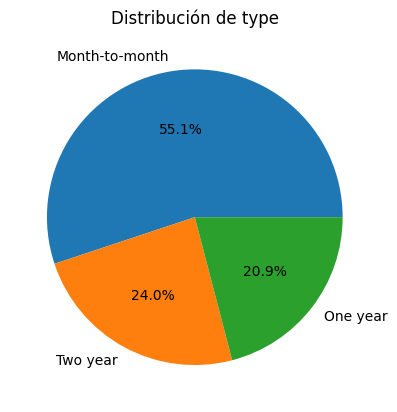

In [221]:
# Analizar al distribución de la columna

analyze_column('type')

La mayoria de los suscriptores, alrededor del 55.1% prefiere pagar sus servicios de forma mensual.

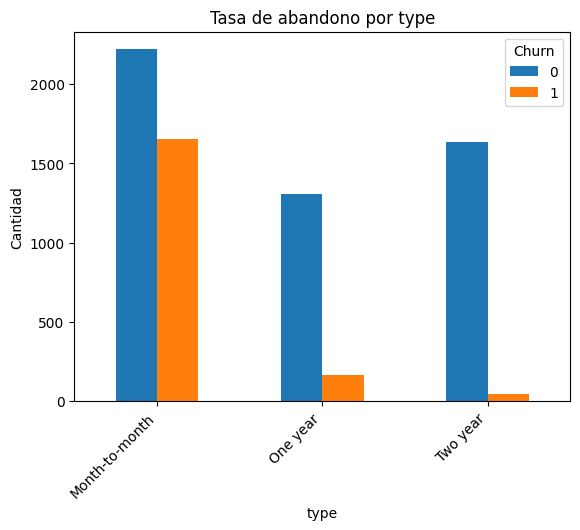

churn,0,1,churn_rate
type,,,
Month-to-month,2220,1655,42.71%
One year,1306,166,11.28%
Two year,1637,48,2.85%


In [222]:
# Calcular la Tasa de Abandono basada en la columna `type` y mostrar su visualización

type_churn_rate = analyze_churn_rate('type')
type_churn_rate

**Hallazgos**

- Los clientes de suscripción mensual son los mas vulnerables para abandonar el servicio, ya que su cancelación es más alta que otros tipos de suscripción. Esto indica, que este tipo de clientes pueden ser mas sensibles a cambios en los precios o en la calidad del servicio, esto los mantiene explorando otras opciones y/o cambio de proveedor.

- Paralelamente, los clientes que optaron por las formas de pago mas extensas(anual o bienal), son clientes más fidelizados y tienen menor potencial de abandono del servicio, lo que deduce como mayor lealtad. Esta lealtad se puede atribuir a diversos factores como inventivos de precio, confianza por la calidad de servicio o un compromiso más fuerte con el uso de servicio a largo plazo.

**Insights**

- El tipo de suscripción desempeña un rol fundamental en la tasa de retención de clientes.

- Ofrecer mayores beneficios e incentivos, para generear compromisos de suscripciones mas largos, puede ser una eficaz estrategia para aumentar la lealtad de los clientes y reducir la tasa de perdida de clientes.

- Monitorear y abordar las necesidades y preocupaciones de los clientes con planes mensuales, lo que ayude a mejorar su satisfacción de los consumidores y dismunir la probabilidad de deserción.

**Recomendaciones**

- Aumentar las promociones e incentivos para las suscripciones más extensas, con el fin de animar a los suscriptores a usar el servicio de forma prologada y asi mejorar la contención.

- Considerar ofrecer tarifas con descuento o características adicionales al servicio básico, para los clientes de contratos anuales o bienales. Abordar estos casos de forma proactiva puede ayudar aumentar la satisfacción del clientes y aminorar la tasa de de cancelación en el segmento.

#### **3.2.2 Columna `payment_method`**

,Cantidad de valores,Porcentajes
payment_method,,
Electronic check,2365,33.63%
Mailed check,1604,22.81%
Bank transfer (automatic),1542,21.93%
Credit card (automatic),1521,21.63%


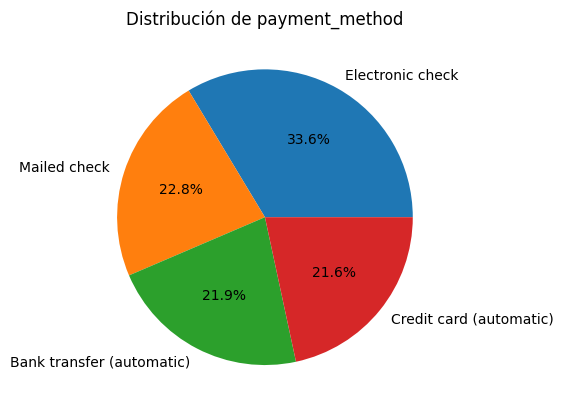

In [223]:
# Analizar al distribución de la columna

analyze_column('payment_method')

La distribución de los consumidores basada en los métodos de pago es relativamente semejante, pero el método de 'cheque electrónico' tiene una participación mayor al resto.

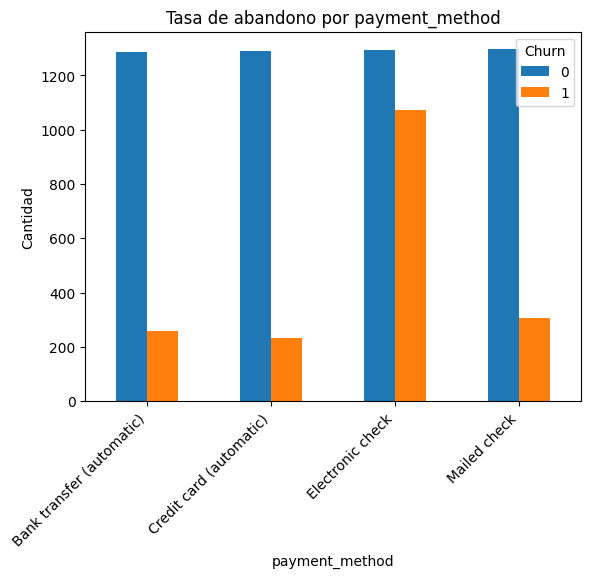

churn,0,1,churn_rate
payment_method,,,
Bank transfer (automatic),1284,258,16.73%
Credit card (automatic),1289,232,15.25%
Electronic check,1294,1071,45.29%
Mailed check,1296,308,19.2%


In [224]:
# Calcular la Tasa de Abandono basada en la columna `payment_method` y mostrar su visualización 

payment_method_churn_rate = analyze_churn_rate('payment_method')
payment_method_churn_rate

**Hallazgos**

- La tasa de abandono para el método de pago de 'cheque electrónico' es significativamente superior, que la de otros medios de pago.

- La 'tarjeta de credito' es el que presenta menor riesgo de deserción.

**Insights**

- La alta tasa de cancelación de los clientes con 'cheque electrónico', puede señalar que estos consideran este medio de pago menos conveniente, comparado con otras opciones. Esto puede ocasionarse por factores como error en las transacciones, demoras en el procesamiento o temas relacionados a la seguridad.

- Por otra parte, la 'tarjeta de crédito' sugiere que los consumidores con este medio pago pueden tener una situacion financiera más estable y se pueden legar a estar mas comprometidos con el uso del servicio. Los pagos con 'tarjeta de crédito' ofrecen facturación automática lo que puede generar una mayor impresión de seguridad, lo que fomenta la retención de clientes.

**Recomendaciones**

- Realizar esfuerzos para incentivar a los suscriptores a modificar su medio de pago, de 'cheque electrónico' por uno más confiable y conveniente. Esto puede incorporar descuentos o promociones para quienes paguen con 'tarjeta de crédito' u otros métodos de baja deserción.

- Implementar incentivos promocionales , con el fin de fomentar el uso de las tarjetas de credito u otro medio de pago con menor riesgo de cancelación, para poder mejorar los niveles de retención. Por último, mejorar la experiencia general de pago para los usuarios de cheques electrónicos, abordando problemas y ofreciendo soporte, esto puede ayudar a reducir la tasa de abandono de este segmento.

#### **3.2.3 Columna `internet_service`**

,Cantidad de valores,Porcentajes
internet_service,,
Fiber optic,3096,44.03%
DSL,2416,34.36%
No internet,1520,21.62%


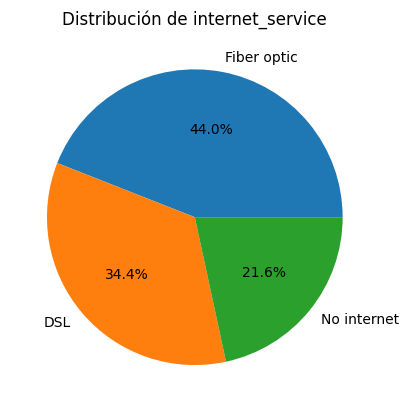

In [225]:
# Analizar al distribución de la columna

analyze_column('internet_service')

La gran mayoria de los suscriptores que tienen servicio de internet, usan fibra óptica, mientras que un alto número de clientes no tienen contratado ningún servicio de internet. 

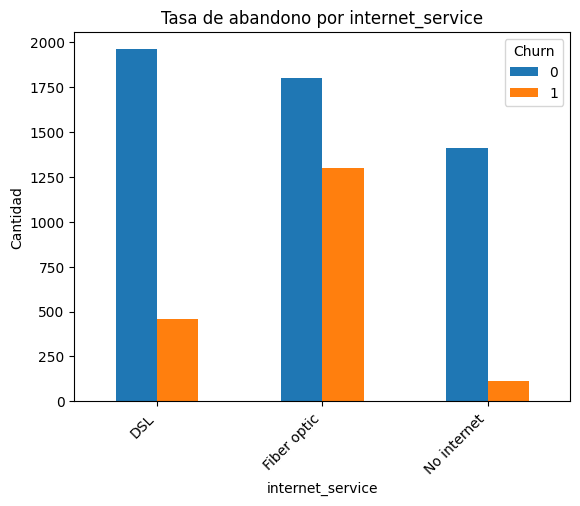

churn,0,1,churn_rate
internet_service,,,
DSL,1957,459,19.0%
Fiber optic,1799,1297,41.89%
No internet,1407,113,7.43%


In [226]:
# Calcular la Tasa de Abandono basada en la columna `internet_service` y mostrar su visualización 

internet_service_churn_rate = analyze_churn_rate('internet_service')
internet_service_churn_rate

**Hallazgos**

- La mayoría de los clientes(44%) utiliza el servicio de internet por fibra óptica, mientras que una cantidad significativa de se clientes no usa ningún tipo de servicio de internet.

- Los suscriptores que usan fibra óptica tienen mayor potencial de abandonar el servicio, en comparación con aquellos que utilizan DSL o que no usan servicios de internet.

**Insights**

- La alta tasa de cancelación entre lso usuarios de internet, especialmente los de fibra óptica, puede atribuirse a factores como la calidad del servicio, velocidad de internet, los precios o la competencia de otros proveedores del servicio de internet.

- Los clientes que no usan servicios de internet, pueden haber optado otros medios de comuniacación o simplemente no tener la necesidad de conectividad, lo que los hace menos propensos a cancelar.

**Recomendaciones**

- Realizar análisis exhaustivo de las razones detras de la alta tasa de cancelación entre los usuarios de fibra óptica. Esto puede incluir la recolección de comentarios de los clientes, la identificación de puntos problematicos y la implementación de mejoras necesarias para aumentar la satisfacción.

- Ofrecer promociones atractivas o incentivos para retener a los clientes actuales de internet por fibra óptica y animarlos a retener el servicio.

- Considerar la diversificación del servicio de internet, el ofrecimiento de DSL u otra altenativa de banda ancha, para adarptarse a las necesidades y/o preferencias de los clientes.

- Los clientes que no utilizan servicios de internet, evaluar oportunidades de ofrecer paquetes básicos de internet u ofertas combinadas que mejoren la experiencia general del usuario.

#### **3.2.4 Columna `gender`**

,Cantidad de valores,Porcentajes
gender,,
Male,3549,50.47%
Female,3483,49.53%


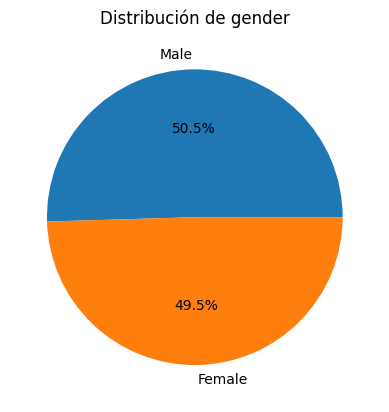

In [227]:
# Analizar al distribución de la columna

analyze_column('gender')

La proporción entre clientes hombres y mujeres es relativamente balanceada.

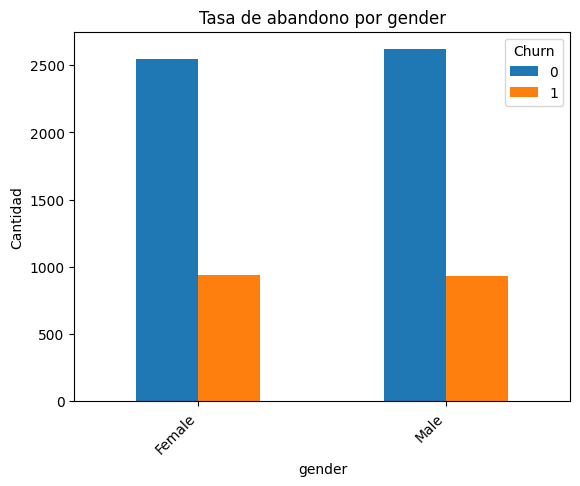

churn,0,1,churn_rate
gender,,,
Female,2544,939,26.96%
Male,2619,930,26.2%


In [228]:
# Calcular la Tasa de Abandono basada en la columna `gender` y mostrar su visualización 

gender_service_churn_rate = analyze_churn_rate('gender')
gender_service_churn_rate

**Hallazgos**

- La tasa de cancelación para clientes hombre o mujeres es similar, lo quew sugiere que el sexo de los suscriptores no influyw significativamente en la probabilidad  de que los clientes abandonen el servicio.

- No se observan diferencias notables en el comportamiento de diserción, entre clientes masculinos y femeninos.

**Insights**

- El análisis sugiere revisar otros factores mas alla del género, que desempeñen un papel más fundamental en la tasa de abandono de los clientes.  Es primordial enfocarse en estos otros factores para entender las razones detras de la pérdida de clientes.

**Recomendaciones**

- En el diseño de programas promocionales o estrategias de reducción de cancelación, se recomienda preferir otros factores más relevantes como el tipo de suscripción, el método de pago, la calidad del servicio de internet y la atención al cliente, ya que su impacto parece ser más significativo en la retención.

- Independiente, que el género no sea una variable relevante para el proyecto, debido a su nula influencia en la tasa de abandono, es necesario seguir realizando investigaciones de mercado continuas y análisis de retroalimentación del cliente para reconocer posibles cambios en las preferencias o en los patrones de comportamientos de estos segmentos.


### **3.3 Balance de clases**

Análisis del desbalance de los datos, reflejado en la variable objetivo, por lo que se estudia la frecuencia de las clases "1" y "0", empleando el metodo value_counts(), el cual entrega la cantidad de ocasiones, que suceden cada una de las clases, lo que proporciona informacion sobre la distribución de las clases, y permite dar coherencia al modelo.

churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


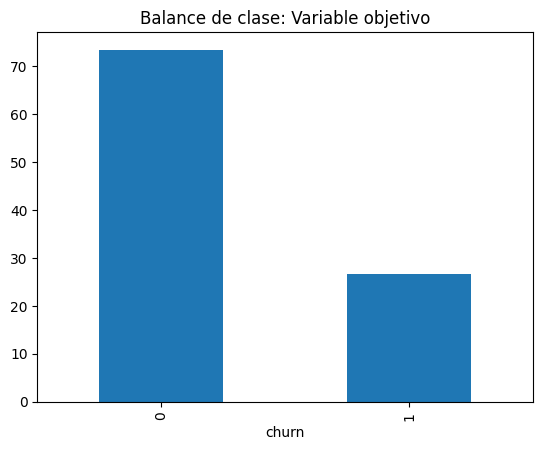

In [229]:
# Verificando desequilibrio de la variable objetivo

class_frequency = data['churn'].value_counts(normalize=True)*100
print(class_frequency)
class_frequency.plot(kind='bar', title='Balance de clase: Variable objetivo');                                                                                                                                                                                                                                                                                        

El desbalance de los datos permite determinar que aproximadamente el 27% de los clientes se fugan de la compañia, y el 73% restante son clientes que estan fidelizados, esta materia se tratará más adelante en el proyecto.

### **3.4 Resumen de la Tasa de Abandono**

Se calculo la tasa de abandono para las características númericas con alta correlación con la variable objetivo, asi como para las variables categóricas. A continuación se resumen los resultados obtenidos.

In [230]:
# Combinación de los resultados de la tasa de abandono
# Especificamente variables binarias (0 y 1) 

df_churn_rate = pd.concat([paperless_churn_rate['churn_rate'],
                           senior_citizen_churn_rate['churn_rate'],
                           online_security_churn_rate['churn_rate'],
                           tech_support_churn_rate['churn_rate'],
                           dependents_churn_rate['churn_rate'],
                           partner_churn_rate['churn_rate']], 
                          axis=1, 
                          keys=['paperless_churn_rate',
                                'senior_citizen_churn_rate',
                                'online_security_churn_rate',
                                'tech_support_churn_rate',
                                'dependents_churn_rate',
                                'partner_churn_rate'])

df_churn_rate.T

,0,1
paperless_churn_rate,16.38%,33.59%
senior_citizen_churn_rate,23.65%,41.68%
online_security_churn_rate,31.37%,14.64%
tech_support_churn_rate,31.23%,15.2%
dependents_churn_rate,31.28%,15.53%
partner_churn_rate,32.98%,19.72%


In [231]:
# Combinación de los resultados de la tasa de abandono
# Especificamente variables 'monthly_charges' y 'total_charge'

df_churn_rate_2 = pd.concat([monthly_charge_churn_rate['churn_rate'],
                             total_charge_churn_rate['churn_rate']], 
                            axis=1,
                            keys=['monthly_charge_churn_rate',
                                  'total_charge_churn_rate',])

df_churn_rate_2.T

,low,mid_low,middle,mid_high,high
monthly_charge_churn_rate,9.84%,31.05%,20.26%,37.99%,32.86%
total_charge_churn_rate,32.06%,23.76%,16.21%,13.84%,3.85%


In [232]:
# Muestra de resultados de la tasa de abandono de variables categóricas

dfs = [type_churn_rate, payment_method_churn_rate, internet_service_churn_rate, gender_service_churn_rate]

for df in dfs:
    display(pd.DataFrame(df['churn_rate']))

,churn_rate
type,
Month-to-month,42.71%
One year,11.28%
Two year,2.85%


,churn_rate
payment_method,
Bank transfer (automatic),16.73%
Credit card (automatic),15.25%
Electronic check,45.29%
Mailed check,19.2%


,churn_rate
internet_service,
DSL,19.0%
Fiber optic,41.89%
No internet,7.43%


,churn_rate
gender,
Female,26.96%
Male,26.2%


### **3.5 Conclusión de resultados EDA**

Se puede deducir,  que son varias las razones que influencian la cancelación del servicio, por ello, se aplicaran las siguientes determinaciones:

- Enfocar el proyecto, en las variables con alta correlación en el riesgo de abandono, se descartan variables de baja correlación.

- Varias características presentan la tasa de cancelación más alta(superior al 40%),como los clientes adultos mayores(41,68%), la suscripción mensual(42,71%), el método de pago por cheque electrónico(45,29%) y el servicio de internet por fibra óptica(41,89%), las cuales requieren un interes especial para mitigar el aumento de la tasa de deserción de clientes.

- Los clientes con pareja/esposa, hijos o alguien dependiente, muestran menor deserción que los clientes solteros, sini hijos o sin alguien dependiente.

- Los clientes que no utilizan servicios de seguridad o soporte técnico presentan un mayor riesgo de cancelación.

- No se observa una diferencia significativa en la tasa de cancelación entre clientes hombres y muejeres.

Mediante estos hallazgos la Interconnect puede diseñar estreategias especificas y desarrollar programas promocionales directos para reterner clientes, enfocandose en las categórias de alto riesgo.

## **4. Entrenamiento y prueba del modelo**

En esta sección, se procede a desarrollar varios modelos de machine learning, con el fin de realizar las predicciones de los datos. 

El objetivo, es lograr la puntuación más alta posible en el conjunto de prueba, utilizando principalmente la métrica AUC-ROC.

Los criterios de evaluación para el modelado son los siguientes:

- AUC-ROC < 0.75 — 0 SP

- 0.75 ≤ AUC-ROC < 0.81 — 4 SP

- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP

- 0.85 ≤ AUC-ROC < 0.87 — 5 SP

- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP

- AUC-ROC ≥ 0.88 — 6 SP

Para ello, se desarrollarán las siguientes etapas:

- Preparar los datos para el modelado, lo que incluye la partición de los datos, la codificación OHE para las variables categóricas, aplicar Boruta(selección de características) y el escalado en los datos de entrenamiento y prueba.

- Entrenar y evaluar distintos modelos de machine learning de clasificación, como Linear Regression, Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost.

- Realizar ajuste de hiperparámetros para obtener el mejor desempeño de los modelos.

Con este procedimiento, se espera desarrollar el mejor modelo de machine learning, robusto y preciso, que pueda predecir de manera efectiva la deserción de clientes, permitiendo a Interconnect tomar medidas proactivas respecto a la retención de clientes. 

### **4.1 Preparación de datos**

Revisar el conjunto de datos, versi cambio alguna variable o si se agregaron algunas nuevas. Posteriormente, identificar las acciones para preparar el set de datos para el modelado y mejorar el conjunto de características.

In [233]:
data.sample(5)

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,charge_category,total_charge_category
5898,8295-KMENE,2015-03,Two year,1,Mailed check,76.45,4519.50,Female,0,1,...,1,0,1,1,1,0,1,0,mid_high,middle
2281,3258-ZKPAI,2014-02,Two year,1,Bank transfer (automatic),116.60,8337.45,Male,0,1,...,1,1,1,1,1,1,1,0,high,high
2362,3387-PLKUI,2019-01,Month-to-month,0,Mailed check,18.80,251.25,Female,0,1,...,0,0,0,0,0,0,0,0,low,low
2264,3235-ETOOB,2019-04,Month-to-month,1,Electronic check,74.50,609.90,Male,0,1,...,1,0,0,0,0,0,0,1,mid_high,low
3364,4797-MIWUM,2019-07,Month-to-month,1,Bank transfer (automatic),20.25,174.70,Male,0,1,...,0,0,0,0,0,0,0,0,low,low


In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   customer_id            7032 non-null   object   
 1   begin_date             7032 non-null   period[M]
 2   type                   7032 non-null   object   
 3   paperless_billing      7032 non-null   int64    
 4   payment_method         7032 non-null   object   
 5   monthly_charges        7032 non-null   float64  
 6   total_charges          7032 non-null   float64  
 7   gender                 7032 non-null   object   
 8   senior_citizen         7032 non-null   int64    
 9   partner                7032 non-null   int64    
 10  dependents             7032 non-null   int64    
 11  internet_service       7032 non-null   object   
 12  online_security        7032 non-null   int64    
 13  online_backup          7032 non-null   int64    
 14  device_protection      7032 n

**Hallazgos**

- `customer_id` no es necesaria para la creación del modelo, por lo que puede eliminarse del conjunto de datos.

- `begin_date` esta en formato period[M]. para mejorar esta variable se dividirá en 2 columnas, mes y año, esto indicará de mejor forma la información temporal al modelo.

- Para los modelos que no procesan variables categóricas de forma directa, se creará un nuevo conjunto de datos, al cual se le aplicará la técnica OHE(one-hot-encoding), la cual convierte todas las variables categóricas en representaciones númericas, esto permite que dichos modelo procesen de forma efectiva la información categórica.

- `monthly_charges` y `total_charges` son variables con un rango amplio de valores, por ello se les aplicarán técnicas de escalado, con el fin de mejorar una la convergencia y tener mayor estabilidad en el entrenamiento del modelo.

Implementar estas acciones permitirá elaborar un modelo de machine learnig robusto y preciso, que prediga efectivamente la deserción de clientes.

#### **4.1.1 Eliminación de variables innecesarias**

In [235]:
# Removiendo `customer_id`

data = data.drop('customer_id', axis=1)

In [236]:
# Partición columna `begin_date` en 2 columnas, mes y año
# Eliminar columna `begin_date` del conjunto de datos

data['begin_date'] = data['begin_date'].astype(str)
data[['year', 'month']] = data['begin_date'].str.split('-', expand=True)
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data = data.drop('begin_date', axis=1)

#### **4.1.2 Partición de datos**

In [237]:
features = data.drop('churn', axis=1)
target = data['churn']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

print("Caratrísticas entrenamiento:", features_train.shape)
print("Características prueba:", features_test.shape)
print("Objetivo entrenamiento:", target_train.shape)
print("Objetivo prueba:", target_test.shape)

features_train['paperless_billing']

Caratrísticas entrenamiento: (5625, 21)
Características prueba: (1407, 21)
Objetivo entrenamiento: (5625,)
Objetivo prueba: (1407,)


4675    1
5475    0
4523    0
1746    1
1575    1
       ..
2865    0
5967    1
784     0
4723    0
1820    0
Name: paperless_billing, Length: 5625, dtype: int64

#### **4.1.3 Codificación de variables categóricas**

In [178]:
# Aplicando técnica OHE para 'features_train' y 'features_test'

features_train = pd.get_dummies(features_train, drop_first=True).astype(int)
features_test = pd.get_dummies(features_test, drop_first=True).astype(int)

In [179]:
features_train.columns

monthlycharges', 'totalcharges', 'seniorcitizen', 'year', 'month',
'type_One year', 'type_Two year', 'paperlessbilling_Yes',
'paymentmethod_Credit card (automatic)',
'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
'gender_Male', 'partner_Yes', 'dependents_Yes',
'internetservice_Fiber optic', 'internetservice_No internet',
'onlinesecurity_Yes', 'onlinebackup_Yes', 'deviceprotection_Yes',
'techsupport_Yes', 'streamingtv_Yes', 'streamingmovies_Yes',
'multiplelines_Yes', 'charge_category_mid_low',
'charge_category_middle', 'charge_category_mid_high',
'charge_category_high', 'total_charge_category_mid_low',
'total_charge_category_middle', 'total_charge_category_mid_high',
'total_charge_category_high'

Index(['paperless_billing', 'monthly_charges', 'total_charges',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'year', 'month', 'type_One year',
       'type_Two year', 'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'gender_Male', 'internet_service_Fiber optic',
       'internet_service_No internet', 'charge_category_mid_low',
       'charge_category_middle', 'charge_category_mid_high',
       'charge_category_high', 'total_charge_category_mid_low',
       'total_charge_category_middle', 'total_charge_category_mid_high',
       'total_charge_category_high'],
      dtype='object')

#### **4.1.4 Boruta**

Previo al escalado de variables y con el fin de identificar las variables relevantes para el modelado, se aplicará la técnica de selección de variables, 'Boruta'.

Este método usa Random Forest para comparar las variables para comparar su real importancia, con esto se mantienen solo las variables que aportan información significativa al modelo, mejorando la efectividad y minimizando el sobreajuste.

In [69]:
boruta_rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, class_weight='balanced')
boruta_selector = BorutaPy(estimator=boruta_rf, n_estimators='auto', verbose=2, random_state=seed)
boruta_selector.fit(features_train.values, target_train.values)
important_features = features_train.columns[boruta_selector.support_].tolist()

print()
print('Variables importantes del conjunto de datos')
print(important_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	20
I

Aplicada la técnica ''Boruta', es necesario hacer una análisis de los conjuntos de datos, ya que la selección de características, entrego como variables importantes 4 columnas, `monthly_charges`, `total_charges`, `year`, `month`, una reducción de dimensionalidad bastante drástica, ya que inicialmente son 31 variables que afectan al modelo.

Por ello, se ha determinado generar una combinación de la información obtenida en el análisis exploratorio de datos y Boruta, ya que se estudiaron variables que si afectan al modelo, el cual 'Boruta' en este caso no las considero.

In [128]:
# Selección de variables (EDA)
# Lista con variables finales
# Filtrar conjuntos de datos por variables 

features_train.columns = features_train.columns.str.replace(' ', '_')
features_test.columns = features_test.columns.str.replace(' ', '_')


eda_features = ['paperless_billing','senior_citizen', 'partner', 'dependents', 'online_security','tech_support','type_One_year','type_Two_year', 'payment_method_Credit_card_(automatic)', 'payment_method_Electronic_check', 'payment_method_Mailed_check', 'internet_service_Fiber_optic', 'internet_service_No_internet', 'charge_category_mid_low', 'charge_category_middle', 'charge_category_mid_high', 'charge_category_high', 'total_charge_category_mid_low', 'total_charge_category_middle', 'total_charge_category_mid_high', 'total_charge_category_high']

final_features = list(set(important_features+eda_features))

features_train = features_train[final_features]
features_test = features_test[final_features]

'Boruta' permitió reducir la dimensionalidad del set de datos, seleccionando únicamente aquellas variables que aportan información significativa para la predicción, además se incorporaron variables adicionales provenientes del análisis exploratorio de datos, las cuales fueron estudiadas y comprabada su influencia en la variable objetivo, lo que complementa de forma robusta el dataset para el modelado, además de mejorar su eficiencia y precención del sobreajuste.

#### **4.1.5 Escalado de características**

In [62]:
# Escalado de variables númericas continuas en el conjunto features_train

cols = ['monthly_charges', 'total_charges', 'year', 'month']
scaler = StandardScaler().fit(features_train[cols])
features_train[cols] = scaler.transform(features_train[cols])
features_train[cols].head()

,monthly_charges,total_charges,year,month
4675,-0.712040,-0.033877,-0.960262,1.561536
5475,-1.510723,-0.417587,-1.472833,-0.682050
4523,0.452705,-0.976557,1.090022,1.000640
1746,0.652376,-0.928759,1.090022,1.561536
1575,0.186478,0.891986,-1.472833,1.561536


In [63]:
# Escalado de variables númericas continuas en el conjunto features_test

features_test[cols] = scaler.transform(features_test[cols])
features_test[cols].head()

,monthly_charges,total_charges,year,month
2122,-1.011546,-0.961067,1.090022,1.281088
3445,0.153199,0.027641,0.064880,-1.242947
6808,-0.512370,-0.989392,1.090022,1.561536
6852,-0.512370,-0.964165,1.090022,1.281088
1475,-1.510723,-0.434405,-1.472833,-0.121154


#### **4.1.6 Balance de clases**

Como se observó al final del análisis exploratorio de datos, las clases de la variable objetivo están en desequilibrio, en este apartado se retomará la situación con el fin de resolver este problema.

Para ello, se implementará la técnica SMOTENC, la cual se adapta al conjunto de datos, el cual tiene muchas variables binarias provenientes de variables categóricas. Esta técnica permite crear nuevas instancias respetando la naturaleza de las variables categóricas, esto mejora la calidad del balanceo y mantiene la integridad de las características.

churn
0    50.0
1    50.0
Name: proportion, dtype: float64


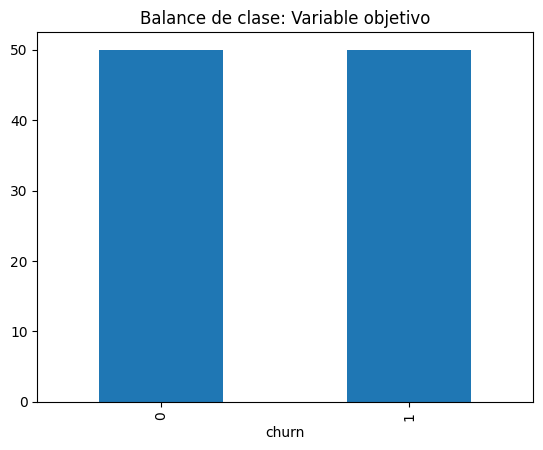

In [64]:
# Aplicar técnica SMOTENC
# Verificar el balance de clases

cat_features = [features_train.columns.get_loc(col) for col in eda_features]
smote_nc = SMOTENC(categorical_features=cat_features, random_state=seed)
features_train, target_train = smote_nc.fit_resample(features_train, target_train)

target_class_frequency = target_train.value_counts(normalize=True)*100
print(target_class_frequency)
target_class_frequency.plot(kind='bar', title='Balance de clase: Variable objetivo');

Los datos estan balanceados.

### **4.2 Entrenamiento del modelo**

#### **4.2.1 Crear funciones de evaluación**

Las métricas que se van a utilizar para evaluar los modelos de machine learning son AUC-ROC, F1-Score y Accuracy. Para hacer más eficiente esta tarea se crearán 2 funciones, que a continuación se explica en detalle lo que realizan, pero por optimización del codigo estan al inicio del proyecto en el apartado de 'Funciones'.

* Función calcule_metrics
    
    Esta función evalua los modelos implementados sin ajuste de hiperparámetros. Calcula la puntuación de AUC-ROC para el set de entrenamiento mediante validación cruzada, F1-Score y Accuracy evaluan las predicciones realizadas sobre 'features_train' sin validacdión cruzada. Luego se aplicaran los modelos al conjunto de prueba para calcular AUC-ROC, F1-Score y Accuracy.

* Función hyperparam_tuning_calcule_metrics
    
    Esta función evalua los modelos implementados con el ajuste de hiperparámetos, con el fin de perfeccionar las puntuaciones de AUC-ROC. F1-Score y Accuracy. Por último, despues de ajustar el modelo, se utilizará para predecir sobre el conjunto de prueba y calcular las puntuaciones de las métricas mencionadas, basadas en el rendimiento del modelo ajustado. 

#### **4.2.2 Logistic Regression**

In [65]:
%%time

lr = LogisticRegression().fit(features_train, target_train)

lr_score = calculate_metrics(lr, features_train, target_train, features_test, target_test, 'Logistic Regression')

lr_score

CPU times: total: 453 ms
Wall time: 470 ms


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Logistic Regression,0.86911,0.762649,0.801298,0.639911,0.793045,0.770434


In [66]:
%%time


lr_hyper_tuning = LogisticRegression()
param_distributions = {'C': [0.1, 1, 10],
                       'penalty': ['l1', 'l2'],
                       'solver': ['liblinear', 'saga'],
                       'max_iter': [100, 200, 300],
                       'random_state': [seed]}

lr_hyper_tuning_score = hyperparam_tuning_calcule_metrics(lr_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'Logistic Regression')

lr_hyper_tuning_score

Mejores parámetros: {'solver': 'liblinear', 'random_state': 200, 'penalty': 'l1', 'max_iter': 300, 'C': 10}
CPU times: total: 984 ms
Wall time: 6.46 s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Logistic Regression,0.874478,0.853061,0.802647,0.644295,0.794736,0.773987


Luego de aplicar los hiperparámetros al modelo de 'Logistic Regression', la puntuación de AUC-ROC en el conjunto de prueba, muestra que su desempeño mejoró notablemente, no asi el resto de las métricas que mantuvieron aproximadamente sus puntuaciones.

#### **4.2.3 Decision Tree Classifier**

In [67]:
%%time

dtc = DecisionTreeClassifier().fit(features_train, target_train)
dtc_score = calculate_metrics(dtc, features_train, target_train, features_test, target_test, 'Decision Tree Classifier')

dtc_score

CPU times: total: 328 ms
Wall time: 356 ms


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Decision Tree Classifier,0.84738,0.785412,1.0,0.684343,1.0,0.822317


In [68]:
%%time

dtc_hyper_tuning = DecisionTreeClassifier()
param_distributions = {'criterion': ['gini', 'entropy'],
                       'max_depth': [None, 10, 20, 30],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 2, 4],
                       'max_features': ['sqrt', 'log2', None],
                       'random_state': [seed]}

dtc_hyper_tuning_score = hyperparam_tuning_calcule_metrics(dtc_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'Decision Tree Classifier')

dtc_hyper_tuning_score

Mejores parámetros: {'random_state': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
CPU times: total: 594 ms
Wall time: 796 ms


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Decision Tree Classifier,0.94108,0.862136,0.854805,0.65122,0.856436,0.796731


Las puntuaciones se superaron y los tiempo de ejecución son relativamente breves. 

El modelo sin ajuste de hiperparámetros tiene sobreajuste en las métricas F1-Score y Accuracy, como señala el puntaje 1 en el entrenamiento, por el contrario a los datos de prueba que es mucho menor. Finalmente al ajustar los hiperparámetros el modelo se volvió mas balanceado, generaliza mejor lo que lo hace mas realista.

#### **4.2.4 Random Forest Classifier**

In [69]:
%%time

rfc = RandomForestClassifier().fit(features_train, target_train)
rfc_score = calculate_metrics(rfc, features_train, target_train, features_test, target_test, 'Random Forest Classifier')

rfc_score

CPU times: total: 6 s
Wall time: 6.03 s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Random Forest Classifier,0.95192,0.785972,1.0,0.69344,1.0,0.837242


In [70]:
%%time

rfc_hyper_tuning = RandomForestClassifier()
param_distributions = {'n_estimators': [100, 200, 300, 400, 500],
                       'criterion': ['gini', 'entropy'],
                       'max_depth': [None, 10, 20, 30, 40, 50],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 2, 4],
                       'max_features': ['sqrt', 'log2'],
                       'bootstrap': [True, False],
                       'random_state': [seed]}

rfc_hyper_tuning_score = hyperparam_tuning_calcule_metrics(rfc_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'Random Forest Classifier')

rfc_hyper_tuning_score

Mejores parámetros: {'random_state': 200, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': False}
CPU times: total: 5.92 s
Wall time: 40.5 s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Random Forest Classifier,1.0,0.892126,0.999758,0.70137,0.999759,0.84506


El desempeño de este modelo, es mejor que los anteriores, sin embargo se evidencia sobreajuste en los datos de entrenamiento en todas las metricas, al implementar sin ajuste de hiperparámetros. El ajuste de hiperparámetros, mantiene la gran capacidad de aprender de los datos de entrenamiento, que para las métricas AUC-ROC y Accuracy, la baja de rendimiento con los datos de prueba es relativamente esperable, pero F1-Score cae demasiado, con datos nunca vistos.

#### **4.2.5 XGBoost Classifier**

In [71]:
%%time

xgbc = XGBClassifier().fit(features_train, target_train)
xgbc_score = calculate_metrics(xgbc, features_train, target_train, features_test, target_test, 'XGBoost Classifier')

xgbc_score

CPU times: total: 10.2 s
Wall time: 1.97 s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,XGBoost Classifier,0.969549,0.848096,0.983339,0.793388,0.983458,0.89339


In [72]:
%%time

xgbc_hyper_tuning = XGBClassifier()
param_distributions = {'max_depth'    : sp_randInt(5, 50),
                       'n_estimators' : sp_randInt(50, 800),    
                       'learning_rate': sp_randFloat(),    
                       'subsample'    : sp_randFloat(),
                       'random_state' : [seed]}

xgbc_hyper_tuning_score = hyperparam_tuning_calcule_metrics(xgbc_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'XGBoost Classifier')

xgbc_hyper_tuning_score

Mejores parámetros: {'learning_rate': np.float64(0.5677350437652839), 'max_depth': 8, 'n_estimators': 617, 'random_state': 200, 'subsample': np.float64(0.958082993629526)}
CPU times: total: 11.9 s
Wall time: 15.8 s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,XGBoost Classifier,1.0,0.94301,0.999879,0.825789,0.999879,0.909737


El modelo XGBoost Classifier alcanza puntuaciones muy altas con los datos de entrenamiento, llegando al 1 con los datos de entrenamiento y con ajuste de hiperparámetros. El puntaje obtenido con los datos de prueba es muy alto superando el 0,88 que es el umbral minimo del criterio de evaluación 6 SP. Si bien existe una diferencia entre las puntuaciones de entrenamiento y prueba, es algo esperable.

#### **4.2.6 LightGBM Classifier**

In [73]:
%%time

lgbmc = LGBMClassifier().fit(features_train, target_train)
lgbmc_score = calculate_metrics(lgbmc, features_train, target_train, features_test, target_test, 'LightGBM Classifier')

lgbmc_score

[LightGBM] [Info] Number of positive: 4141, number of negative: 4141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 8282, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3313, number of negative: 3312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 6625, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500075 -> initscore=0.000302


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,LightGBM Classifier,0.962952,0.831854,0.948185,0.770515,0.949167,0.882729


In [74]:

%%time

lgbmc_hyper_tuning = LGBMClassifier()
param_distributions = {'max_depth'    : sp_randInt(5, 50),    
                       'n_estimators' : sp_randInt(50, 800),    
                       'learning_rate': sp_randFloat(),    
                       'subsample'    : sp_randFloat(),
                       'random_state' : [seed]}

lgbmc_hyper_tuning_score = hyperparam_tuning_calcule_metrics(lgbmc_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'LightGBM Classifier')

lgbmc_hyper_tuning_score

[LightGBM] [Info] Number of positive: 4141, number of negative: 4141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 8282, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,LightGBM Classifier,1.0,0.942806,1.0,0.809917,1.0,0.901919


Al igual que el modelo anterior, LightGBM Classifier, alcanza el puntaje perfecto con el conjunto de entrenamiento, pero al exponerlo al conjunto de prueba su rendimiento no es superior al de XGBoost Classifier.

#### **4.2.7 CatBoost Classifier**

In [75]:
%%time

cbc = CatBoostClassifier(verbose=500).fit(features_train, target_train)
cbc_score = calculate_metrics(cbc, features_train, target_train, features_test, target_test, 'CatBoost Classifier')

cbc_score

Learning rate set to 0.025408
0:	learn: 0.6782392	total: 136ms	remaining: 2m 15s
500:	learn: 0.2382230	total: 3.04s	remaining: 3.02s
999:	learn: 0.1689118	total: 6.06s	remaining: 0us
Learning rate set to 0.023098
0:	learn: 0.6779783	total: 5.35ms	remaining: 5.34s
500:	learn: 0.2073942	total: 2.68s	remaining: 2.67s
999:	learn: 0.1364192	total: 5.43s	remaining: 0us
Learning rate set to 0.023098
0:	learn: 0.6790943	total: 5.72ms	remaining: 5.72s
500:	learn: 0.2276874	total: 2.72s	remaining: 2.71s
999:	learn: 0.1555485	total: 5.43s	remaining: 0us
Learning rate set to 0.0231
0:	learn: 0.6800642	total: 6.61ms	remaining: 6.6s
500:	learn: 0.2681701	total: 3.1s	remaining: 3.08s
999:	learn: 0.1913382	total: 6.09s	remaining: 0us
Learning rate set to 0.0231
0:	learn: 0.6800966	total: 6.24ms	remaining: 6.23s
500:	learn: 0.2665488	total: 2.73s	remaining: 2.72s
999:	learn: 0.1908171	total: 5.61s	remaining: 0us
Learning rate set to 0.0231
0:	learn: 0.6802394	total: 7.9ms	remaining: 7.89s
500:	learn: 0

,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,CatBoost Classifier,0.963584,0.839646,0.948413,0.78069,0.949167,0.886994


In [76]:
%%time

cbc_hyper_tuning = CatBoostClassifier(verbose=500)

param_distributions = {'max_depth'    : sp_randInt(5, 15),    
                       'n_estimators' : sp_randInt(50, 500),    
                       'learning_rate': sp_randFloat(),    
                       'subsample'    : sp_randFloat(),
                       'random_state' : [seed]}

cbc_hyper_tuning_score = hyperparam_tuning_calcule_metrics(cbc_hyper_tuning, param_distributions, features_train, target_train, features_test, target_test, 'CatBoost Classifier')

cbc_hyper_tuning_score

0:	learn: 0.5317351	total: 7.41ms	remaining: 3.54s
478:	learn: 0.0288707	total: 2.34s	remaining: 0us
Mejores parámetros: {'learning_rate': np.float64(0.5173522229752766), 'max_depth': 5, 'n_estimators': 479, 'random_state': 200, 'subsample': np.float64(0.5183251337455184)}
CPU times: total: 22.9 s
Wall time: 9min 58s


,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,CatBoost Classifier,0.99999,0.946387,0.999276,0.822888,0.999276,0.907605


El modelo CatBoost Classifier, tambien tiene un desempeño competitivo, ya que con todas las métricas esta alrededor del valor 1, con los datos de entrenamiento y luego de ajustar hiperparámetros. La puntuación obtenida con el conjunto de prueba es destacadamente alto, lo que indica que el modelo generaliza bien los datos nuevos.

### **4.3 Conclusión del capítulo**

Finalmente, se llevo a cabo el entrenamiento y prueba de varios modelos, donde la mayoría a obtenido puntuaciones bastante altas, alcanzando el valor 1 con el conjunto de entrenamiento, especificamente los modelos que tenian ajuste de hiperparámetros, aun asi, es importante señalar que alcanzar un rendimiento perfecto con los datos de entrenamiento no garantiza un desempeño perfectos con los datos de prueba o datos no vistos.

Los puntajes son alentadores, pero se debe considerar precavidamente el potencial de sobreajuste de los modelos, sobre todo en los modelos con puntaje perfecto en los conjuntos de entrenamiento. Para la selección del modelo final, es esencial priorizar el rendimiento en el conjunto de prueba, que es un mejor indicador de como el modelo procesa y generaliza los datos nuevos.

A continuación, se muestra un resumen de los puntajes obtenidos para las tres métricas: AUC-ROC, F1-Score y Accuracy.

In [77]:
# Dataframe con los resultados obtenidos de los diferentes modelos

combined_scores = pd.concat([lr_hyper_tuning_score, dtc_hyper_tuning_score, rfc_hyper_tuning_score, xgbc_hyper_tuning_score, lgbmc_hyper_tuning_score, cbc_hyper_tuning_score], ignore_index=True)

combined_scores

,Modelo,AUC-ROC Entrenamiento,AUC-ROC Prueba,F1-Score Entrenamiento,F1-Score Prueba,Accuracy Entrenamiento,Accuracy Prueba
0,Logistic Regression,0.874478,0.853061,0.802647,0.644295,0.794736,0.773987
1,Decision Tree Classifier,0.941080,0.862136,0.854805,0.651220,0.856436,0.796731
2,Random Forest Classifier,1.000000,0.892126,0.999758,0.701370,0.999759,0.845060
3,XGBoost Classifier,1.000000,0.943010,0.999879,0.825789,0.999879,0.909737
4,LightGBM Classifier,1.000000,0.942806,1.000000,0.809917,1.000000,0.901919
5,CatBoost Classifier,0.999990,0.946387,0.999276,0.822888,0.999276,0.907605


## **5. Conclusión general**

En este proyecto, luego de diversas etapas, como el preprocesamiento, el analisis exploratorio, la selección e ingeniería de características y la codificación de datos, se fraccionaron los datos en conjuntos de entrenamiento y prueba, a los cuales, se les  tuvo que escalar las variables númericas con valores de rangos amplios y finalmente el balance de las clases de la variable objetivo, al implementar la técnica 'SMOTENC', todo esto, con el objetivo de tener un proceso de modelado efectivo.

Los modelos ha usar en el proyecto, fueron entrenados y probados sin ajuste de hiperparámetros, los cuales alcanzaron altas puntuaciones sin modificaciones. Sin embargo, los modelos más complejos como **XGBoost Classifier**, **LightGBM Classifier** y **CatBoost Classifier** evidenciaron un rendimiento superior, obteniendo puntaciones perfectas en los conjuntos de entrenamiento, en las tres métricas, tras el ajuste de los hiperparámetros.

El modelo **XGBoost Classifier**, entrenado y con ajuste de hiperparámetros, destaca como el modelo con mejor rendimiento entre todos. Su destacado puntaje en **AUC-ROC** de **0.9430**, en **F1-Score** de **0.8257(mejor puntuación)** y en **Accuracy** de **0.9097(mejor puntuación)** con el conjunto de prueba, lo manifiesta ser altamente efectivo para predecir el riesgo de fuga de los clientes.

El modelo **CatBoost Classifier** tambien demostró un desempeño robusto, al obtener una puntuación en AUC-ROC ligeramente mayor en el conjunto de prueba comparado con **XGBoost Classifier**, pero descompensado por un F1-Score y Accuracy ligeramente inferior.

Finalmente, ambos modelos revelan extraordinarias capacidades predictivas y pueden ser valorados como los candidatos primordiales para la selección final del modelo recomendado para predecir el riesgo de deserción de los clientes. Sus altas puntuaciones tanto en AUC-ROC, como en F1-Score y Accuracy, los convierten en herramientas sumamente valiosas para Interconnect a la hora de identificar clientes con alto riesgo de abandonar el servicio de la compañia, lo que les permite diseñar y promover estrategias especificas para aumentar la retención de clientes valiosos. 